In [1]:
from UtilDatasetPrepFromLORE import *
from Rankers import *
from PreferentialSampling import *
from UniformSampling import *
from StandardEval import *
from FairnessEval import *
from Explainers import *

22-Feb-14 10:53:23 fatf.utils.array.tools INFO     Using numpy's numpy.lib.recfunctions.structured_to_unstructured as fatf.utils.array.tools.structured_to_unstructured and fatf.utils.array.tools.structured_to_unstructured_row.


# COMPAS

## Uniform Sampling

In [2]:
filename = 'compas-scores-two-years.csv'
path_data = 'datasets/'
path_res = '/Users/Marta/FAccT/Res-COMPAS/'
sensitive = ['race'] #OR sex
df = prepare_compass_dataset(filename, path_data, sensitive)
df

age  sex  priors_count  days_b_screening_arrest  c_charge_degree  \
0      69    1             0                        1                0   
1      34    1             0                        1                0   
2      24    1             4                        1                0   
5      44    1             0                        0                1   
6      41    1            14                        1                0   
...   ...  ...           ...                      ...              ...   
7209   23    1             0                        1                0   
7210   23    1             0                        1                0   
7211   57    1             0                        1                0   
7212   33    0             3                        1                1   
7213   23    0             2                        2                0   

      is_recid  is_violent_recid  two_year_recid  length_of_stay  target  \
0            0                 0               0               0       0   
1            1                 1               1              10       0   
2            1                 0               1               1       0   
5            0                 0               0               1       0   
6            1                 0               1               6       0   
...        ...               ...             ...             ...     ...   
7209         0                 0               0               1       1   
7210         0                 0               0               1       0   
7211         0                 0               0               1       0   
7212         0                 0               0               1       0   
7213         1                 0               1               1       0   

      race_African-American  race_Asian  race_Caucasian  race_Hispanic  \
0                         0           0               0              0   
1                         1           0               0              0   
2                         1           0               0              0   
5                         0           0               0              0   
6                         0           0               1              0   
...                     ...         ...             ...            ...   
7209                      1           0               0              0   
7210                      1           0               0              0   
7211                      0           0               0              0   
7212                      1           0               0              0   
7213                      0           0               0              1   

      race_Native-American  race_Other  
0                        0           1  
1                        0           0  
2                        0           0  
5                        0           1  
6                        0           0  
...                    ...         ...  
7209                     0           0  
7210                     0           0  
7211                     0           1  
7212                     0           0  
7213                     0           0  

[6172 rows x 16 columns]

In [3]:
target = 'target'
column_names = df.columns.values.tolist()
column_names.remove(target)
class_names=['Medium-Low','High']
adClass=0
disClass=1
protected = ['race_African-American','race_Asian','race_Caucasian','race_Hispanic','race_Native-American','race_Other']
protected_feature='races' 
non_sensitive = [elem for elem in column_names if elem not in protected]
adAttr=None#'race_Caucasian'
disAttr=None#'race_African-American'

In [4]:
X,Y,X_blind,X_train,X_test,y_train,y_test,df=prepare_for_sampling(df,protected)

In [5]:
X_test = pd.DataFrame(X_test, columns=column_names)
X_test = X_test.sample(300)
y_test = y_test[X_test.index]
X_test = X_test.values

In [6]:
findFreq(target,protected,df)

({'race_African-American': 1381,
  'race_Asian': 22,
  'race_Caucasian': 1244,
  'race_Hispanic': 300,
  'race_Native-American': 3,
  'race_Other': 222},
 {'race_African-American': 838,
  'race_Asian': 3,
  'race_Caucasian': 231,
  'race_Hispanic': 45,
  'race_Native-American': 6,
  'race_Other': 25})

In [7]:
df_new=UniformSampling(target,protected,df,adClass,disClass,adAttr,disAttr)

Counting labels = 0  {'race_African-American': 1381, 'race_Asian': 22, 'race_Caucasian': 1244, 'race_Hispanic': 300, 'race_Native-American': 3, 'race_Other': 222}
Counting labels = 1  {'race_African-American': 838, 'race_Asian': 3, 'race_Caucasian': 231, 'race_Hispanic': 45, 'race_Native-American': 6, 'race_Other': 25}
DN  ('race_African-American', 838)
FP  ('race_Caucasian', 1244)
DP  ('race_African-American', 1381)
FN  ('race_Caucasian', 231)
Len DN_df  838
Len FP_df  1244
Len DP_df  1381
Len FN_df  231


elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


Len restData 626
DN_expected  642
196 to be removed
Len DN_df after sampling  642
FP_expected  1048
196 to be removed
Len FP_df after sampling  1048
DP_expected  1577
196 to add
Len DP_df after sampling  1577
FN_expected  427
196 to add
Len FN_df after sampling  427


In [8]:
findFreq(target,protected,df_new)

({'race_African-American': 1577,
  'race_Asian': 22,
  'race_Caucasian': 1048,
  'race_Hispanic': 300,
  'race_Native-American': 3,
  'race_Other': 222},
 {'race_African-American': 642,
  'race_Asian': 3,
  'race_Caucasian': 427,
  'race_Hispanic': 45,
  'race_Native-American': 6,
  'race_Other': 25})

In [9]:
X_train,X_train_blind,X_train_mod,X_train_mod_blind,y_train_mod,X_test,X_test_blind=prepare_for_classification(df_new,X_train,X_test,column_names,protected,False)

### MLP

In [10]:

clf = MLPClassifier()
param_grid = dict(hidden_layer_sizes=[(50, 50, 50), (50, 100, 50)],
                          activation=['tanh', 'relu'],
                          solver=['sgd', 'adam'],
                          alpha=[0.0001, 0.05],
                          learning_rate=['constant', 'adaptive']
                          )

In [11]:

clfOrig,clfOrigBlind,clfMit,clfMitBlind,res = Classifiers(clf,param_grid,target,column_names,X_train,X_train_mod,X_train_blind,X_train_mod_blind,y_train,y_train_mod,X_test,X_test_blind,y_test,protected,adClass,disClass,adAttr,disAttr)
res.to_csv(path_or_buf=path_res+'US_MLP_Performances.csv')
res

Original Train Dimension = 4320
Mitigated Train Dimension = 4320
Test Dimension = 300


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer

---> CLF Original: 
Favoured attribute value: [ race_Caucasian ] Freq.: [ 105 ] Labeled as + class: [ 95 ]
Unfavoured attribute value: [ race_African-American ] Freq.: [ 152 ] Labeled as + class: [ 106 ]
---> CLF Mitigated: 
Favoured attribute value: [ race_Caucasian ] Freq.: [ 105 ] Labeled as + class: [ 91 ]
Unfavoured attribute value: [ race_African-American ] Freq.: [ 152 ] Labeled as + class: [ 116 ]
---> CLF Original Blind: 
Favoured attribute value: [ race_Caucasian ] Freq.: [ 105 ] Labeled as + class: [ 93 ]
Unfavoured attribute value: [ race_African-American ] Freq.: [ 152 ] Labeled as + class: [ 111 ]
---> CLF Mitigated Blind: 
Favoured attribute value: [ race_Caucasian ] Freq.: [ 105 ] Labeled as + class: [ 92 ]
Unfavoured attribute value: [ race_African-American ] Freq.: [ 152 ] Labeled as + class: [ 110 ]


CLF Original  CLF Original Blind  CLF Mitigated  \
F1 Score            0.661417            0.645669       0.617886   
Discrimination      0.207393            0.155451       0.103509   

                CLF Mitigated Blind           Best Score  Delta O-OB  \
F1 Score                   0.677165  CLF Mitigated Blind    0.015748   
Discrimination             0.152506        CLF Mitigated    0.051942   

                Delta M-MB  Delta O-M  Delta OB-MB  
F1 Score          0.059279   0.043531     0.031496  
Discrimination    0.048997   0.103885     0.002945

In [12]:

PIK = "US_Clfs_MLP.dat"
with open(path_res+"/"+PIK, "wb") as f:
  pickle.dump([clfOrig,clfOrigBlind,clfMit,clfMitBlind], f)

In [13]:
PIK = "US_Clfs_MLP.dat"
with open(path_res+"/"+PIK, "rb") as f:
  clfOrig,clfOrigBlind,clfMit,clfMitBlind = pickle.load(f)
clfs={'clfOrig':clfOrig,'clfOrigBlind':clfOrigBlind,'clfMit':clfMit,'clfMitBlind':clfMitBlind}

In [14]:
res = pd.read_csv(path_res+'US_MLP_Performances.csv',index_col=0)
res = res.round(3)
res.to_csv(path_res+'US_MLP_Performances.csv')
res

CLF Original  CLF Original Blind  CLF Mitigated  \
F1 Score               0.661               0.646          0.618   
Discrimination         0.207               0.155          0.104   

                CLF Mitigated Blind           Best Score  Delta O-OB  \
F1 Score                      0.677  CLF Mitigated Blind       0.016   
Discrimination                0.153        CLF Mitigated       0.052   

                Delta M-MB  Delta O-M  Delta OB-MB  
F1 Score             0.059      0.044        0.031  
Discrimination       0.049      0.104        0.003

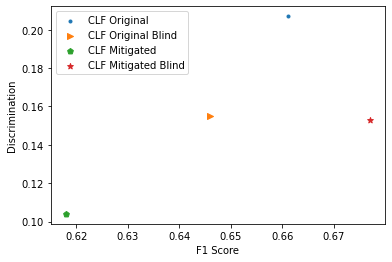

In [15]:
plotDisc(res)

In [16]:
FATInput=DataDescription(X_test,y_test,class_names,column_names,protected,protected_feature)

The grouping based on the *races* feature has the following distribution:
    * "('race_African-American',)" grouping has 152 instances.
    * "('race_Asian',)" grouping has 1 instances.
    * "('race_Caucasian',)" grouping has 105 instances.
    * "('race_Hispanic',)" grouping has 32 instances.
    * "('race_Other',)" grouping has 10 instances.

The class distribution per sub-population:
    * For the "('race_African-American',)" grouping the classes are distributed as follows:
        - The class *Medium-Low* has 98 data points.
        - The class *High* has 54 data points.
    * For the "('race_Asian',)" grouping the classes are distributed as follows:
        - The class *Medium-Low* has 1 data points.
    * For the "('race_Caucasian',)" grouping the classes are distributed as follows:
        - The class *Medium-Low* has 93 data points.
        - The class *High* has 12 data points.
    * For the "('race_Hispanic',)" grouping the classes are distributed as follows:
        - The 

In [17]:
resDisparateImp=disparateImpactMetrics(clfs,FATInput,X_test,X_test_blind,y_test,protected_feature)
resDisparateImp

Some of the given labels are not present in either of the input arrays: {1}.
Some of the given labels are not present in either of the input arrays: {1}.
Some of the given labels are not present in either of the input arrays: {1}.


The *Equal Accuracy* group-based fairness metric for *races* feature split are:
    *  NOT  satisfied for "('race_African-American',)" and "('race_Asian',)" sub-populations.
    *  NOT  satisfied for "('race_African-American',)" and "('race_Other',)" sub-populations.
The *Equal Opportunity* group-based fairness metric for *races* feature split are:
The *Demographic Parity* group-based fairness metric for *races* feature split are:
The *Equal Accuracy* group-based fairness metric for *races* feature split are:
    *  NOT  satisfied for "('race_African-American',)" and "('race_Asian',)" sub-populations.
    *  NOT  satisfied for "('race_African-American',)" and "('race_Other',)" sub-populations.
The *Equal Opportunity* group-based fairness metric for *races* feature split are:
The *Demographic Parity* group-based fairness metric for *races* feature split are:
    *  NOT  satisfied for "('race_African-American',)" and "('race_Asian',)" sub-populations.
    *  NOT  satisfied for "('race_Af

Some of the given labels are not present in either of the input arrays: {1}.


{'Equal Accuracy': {'Delta O-OB': [],
  'Delta M-MB': ["'race_African-American' 'race_Asian' ",
   "'race_African-American' 'race_Other' "],
  'Delta O-M': [],
  'Delta OB-MB': ["'race_African-American' 'race_Asian' ",
   "'race_African-American' 'race_Other' "]},
 'Equal Opportunity': {'Delta O-OB': [],
  'Delta M-MB': [],
  'Delta O-M': [],
  'Delta OB-MB': []},
 'Demographic Parity': {'Delta O-OB': ["'race_African-American' 'race_Asian' ",
   "'race_African-American' 'race_Other' ",
   "'race_African-American' 'race_Hispanic' "],
  'Delta M-MB': ["'race_African-American' 'race_Asian' ",
   "'race_African-American' 'race_Other' "],
  'Delta O-M': ["'race_African-American' 'race_Asian' ",
   "'race_African-American' 'race_Other' "],
  'Delta OB-MB': ["'race_African-American' 'race_Asian' ",
   "'race_African-American' 'race_Other' ",
   "'race_African-American' 'race_Hispanic' "]}}

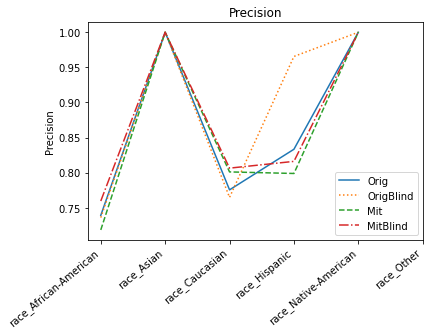

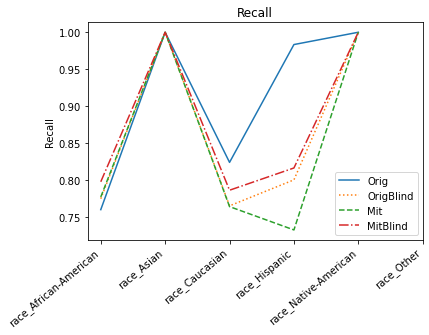

In [18]:
standardMetricsPerGroup(clfs,column_names,target,X_test,y_test,protected_feature,protected)

#### XAI Fixed Reference Set

##### SHAP Kernel Explainer

In [19]:
shap_v = SHAP(clfs,column_names,X_train,X_train_mod,X_test,protected,changeReferenceSet=False,Tree=False)  
XAISum,XAIMean = deltas(shap_v,column_names)
resSHAP = buildFinalResXAI(XAISum,XAIMean,protected,non_sensitive)

In [20]:
PIK = "US_MLP_SHAPV_Fix.dat"
with open(path_res+"/"+PIK, "wb") as f:
  pickle.dump(shap_v, f)

In [4]:
PIK = "US_MLP_SHAPV_Fix.dat"
with open(path_res+"/"+PIK, "rb") as f:
  shap_v = pickle.load(f)

In [5]:
XAISum,XAIMean = deltas(shap_v,column_names)
XAISum

Empty DataFrame
Columns: []
Index: []

In [6]:
XAIMean

clfOrig-clfOrigBlind  clfMit-clfMitBlind  \
age                                  0.013976            0.017942   
sex                                  0.006053            0.000450   
priors_count                         0.014323            0.018612   
days_b_screening_arrest              0.007443            0.009780   
c_charge_degree                      0.010398            0.008807   
is_recid                             0.007517            0.004836   
is_violent_recid                     0.003925            0.009742   
two_year_recid                       0.007858            0.006089   
length_of_stay                       0.021276            0.016917   
race_African-American                0.023488            0.001679   
race_Asian                           0.000089            0.000041   
race_Caucasian                       0.000773            0.020148   
race_Hispanic                        0.001575            0.000580   
race_Native-American                 0.000007            0.000000   
race_Other                           0.000524            0.000742   

                         clfOrig-clfMit  clfOrigBlind-clfMitBlind  
age                            0.020116                  0.018278  
sex                            0.005212                  0.001258  
priors_count                   0.019108                  0.015718  
days_b_screening_arrest        0.013379                  0.008475  
c_charge_degree                0.003421                  0.003018  
is_recid                       0.005401                  0.003087  
is_violent_recid               0.000961                  0.005120  
two_year_recid                 0.010872                  0.008948  
length_of_stay                 0.018178                  0.018173  
race_African-American          0.025154                  0.000000  
race_Asian                     0.000048                  0.000000  
race_Caucasian                 0.020051                  0.000000  
race_Hispanic                  0.001251                  0.000000  
race_Native-American           0.000007                  0.000000  
race_Other                     0.000277                  0.000000

In [7]:
EValues = computeE(shap_v,column_names)
EValues 

E
clfOrig-clfOrigBlind      0.008
clfMit-clfMitBlind        0.008
clfOrig-clfMit            0.010
clfOrigBlind-clfMitBlind  0.005

In [8]:
resSHAP = pd.read_csv(path_res+'US_MLP_ResSHAP_Fix.csv',index_col=0)
resSHAP.to_csv(path_or_buf=path_res+'US_MLP_ResSHAP_Fix.csv')
resSHAP

clfOrig-clfOrigBlind  clfMit-clfMitBlind  clfOrig-clfMit  \
SA-Sum                   0.144               0.473           0.608   
SA-Mean                  0.010               0.012           0.010   
NSA-Sum                 17.121              15.339          16.665   
NSA-Mean                 0.018               0.016           0.017   

          clfOrigBlind-clfMitBlind  
SA-Sum                       0.002  
SA-Mean                      0.000  
NSA-Sum                     15.830  
NSA-Mean                     0.013

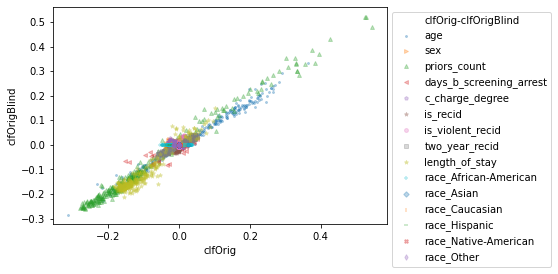

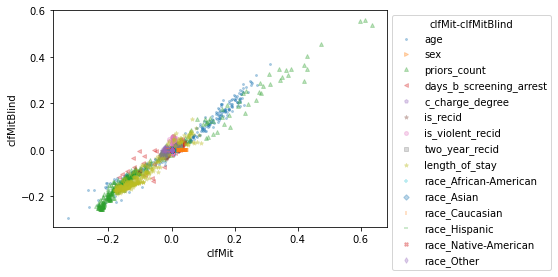

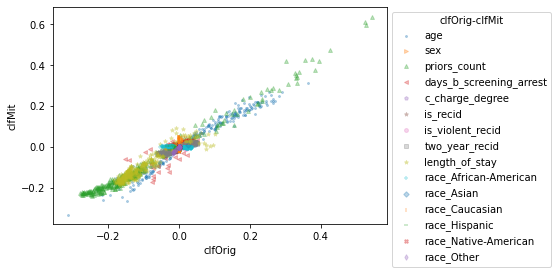

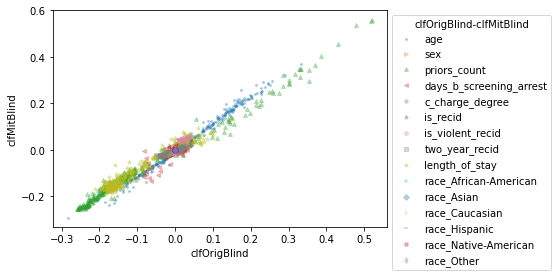

In [28]:
XAIPlots(shap_v,column_names,diffClfs=True)

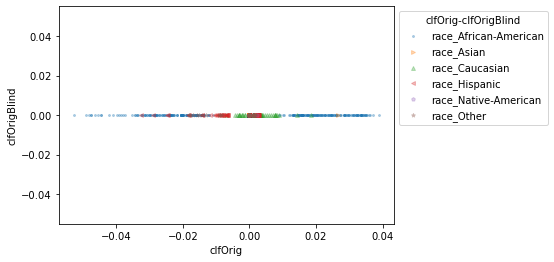

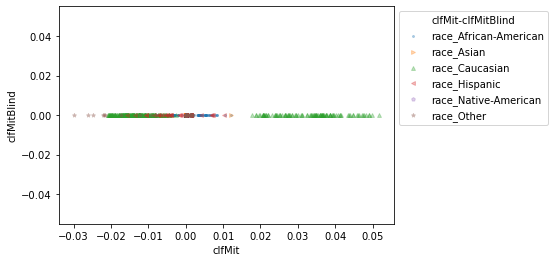

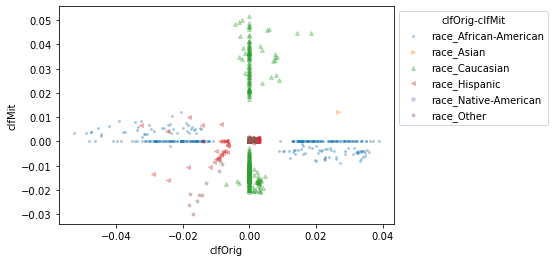

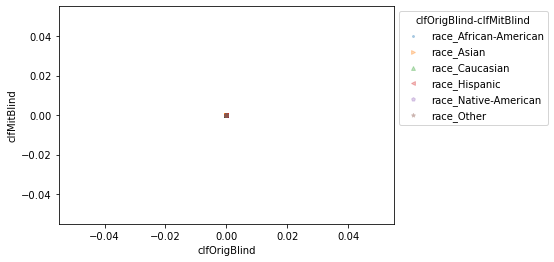

In [29]:
XAIPlots(shap_v,protected,diffClfs=True)

##### LIME

In [ ]:
lime_v= LIME(clfs,column_names,class_names,X_train,X_train_mod,X_test,protected,changeReferenceSet=False)
XAISum,XAIMean = deltas(lime_v,column_names)
resLIME = buildFinalResXAI(XAISum,XAIMean,protected,non_sensitive)

In [ ]:
PIK = "US_MLP_LIMEV_Fix.dat"
with open(path_res+"/"+PIK, "wb") as f:
  pickle.dump(lime_v, f)

In [ ]:
PIK = "US_MLP_LIMEV_Fix.dat"
with open(path_res+"/"+PIK, "rb") as f:
  lime_v = pickle.load(f)

In [ ]:
XAISum,XAIMean = deltas(lime_v,column_names)
XAISum

In [ ]:
XAIMean

In [ ]:
EValues = computeE(lime_v,column_names)
EValues 

In [ ]:
resLIME = pd.read_csv(path_res+'US_MLP_ResLIME_Fix.csv',index_col=0)
resLIME = resLIME.round(3)
resLIME.to_csv(path_or_buf=path_res+'US_MLP_ResLIME_Fix.csv')
resLIME

In [ ]:
XAIPlots(lime_v,column_names,diffClfs=True)

In [ ]:
XAIPlots(lime_v,protected,diffClfs=True)

#### XAI Changing Reference Set

##### SHAP Kernel Explainer

In [ ]:
shap_v = SHAP(clfs,column_names,X_train,X_train_mod,X_test,protected,changeReferenceSet=True,Tree=False)  
XAISum,XAIMean = deltas(shap_v,column_names)
resSHAP = buildFinalResXAI(XAISum,XAIMean,protected,non_sensitive)

In [ ]:
PIK = "US_MLP_SHAPV_Change.dat"
with open(path_res+"/"+PIK, "wb") as f:
  pickle.dump(shap_v, f)

In [ ]:
PIK = "US_MLP_SHAPV_Change.dat"
with open(path_res+"/"+PIK, "rb") as f:
  shap_v = pickle.load(f)

In [ ]:
XAISum,XAIMean = deltas(shap_v,column_names)
XAISum

In [ ]:
XAIMean

In [ ]:
EValues = computeE(shap_v,column_names)
EValues 

In [ ]:
resSHAP = pd.read_csv(path_res+'US_MLP_ResSHAP_Change.csv',index_col=0)
resSHAP = resSHAP.round(3)
resSHAP.to_csv(path_or_buf=path_res+'US_MLP_ResSHAP_Change.csv')
resSHAP

In [ ]:
XAIPlots(shap_v,column_names,diffClfs=True)

In [ ]:
XAIPlots(shap_v,protected,diffClfs=True)

##### LIME

In [ ]:
lime_v= LIME(clfs,column_names,class_names,X_train,X_train_mod,X_test,protected,changeReferenceSet=True)
XAISum,XAIMean = deltas(lime_v,column_names)
resLIME = buildFinalResXAI(XAISum,XAIMean,protected,non_sensitive)

In [ ]:
PIK = "US_MLP_LIMEV_Change.dat"
with open(path_res+"/"+PIK, "wb") as f:
  pickle.dump(lime_v, f)

In [ ]:
PIK = "US_MLP_LIMEV_Change.dat"
with open(path_res+"/"+PIK, "rb") as f:
  lime_v = pickle.load(f)

In [ ]:
XAISum,XAIMean = deltas(lime_v,column_names)
XAISum

In [ ]:
XAIMean

In [ ]:
EValues = computeE(lime_v,column_names)
EValues 

In [ ]:
resLIME = pd.read_csv(path_res+'US_MLP_ResLIME_Change.csv',index_col=0)
resLIME = resLIME.round(3)
resLIME.to_csv(path_or_buf=path_res+'US_MLP_ResLIME_Change.csv')
resLIME

In [ ]:
XAIPlots(lime_v,column_names,diffClfs=True)

In [ ]:
XAIPlots(lime_v,protected,diffClfs=True)

#### Comparison

##### SHAP Kernel Explainer

In [ ]:
PIK = "US_MLP_SHAPV_Fix.dat"
with open(path_res+"/"+PIK, "rb") as f:
  shap_v_fix = pickle.load(f)

In [ ]:
PIK = "US_MLP_SHAPV_Change.dat"
with open(path_res+"/"+PIK, "rb") as f:
  shap_v_change = pickle.load(f)

In [ ]:
XAISum,XAIMean = deltas(shap_v_fix,column_names,False,shap_v_change)
XAISum

In [ ]:
XAIMean

In [ ]:
resSHAP = buildFinalResXAI(XAISum,XAIMean,protected,non_sensitive)
resSHAP = resSHAP.round(3)
resSHAP

In [ ]:
XAIPlots(shap_v_fix,protected,True,shap_v_change)

##### LIME

In [ ]:
PIK = "US_MLP_LIMEV_Fix.dat"
with open(path_res+"/"+PIK, "rb") as f:
  lime_v_fix = pickle.load(f)

In [ ]:
PIK = "US_MLP_LIMEV_Change.dat"
with open(path_res+"/"+PIK, "rb") as f:
  lime_v_change = pickle.load(f)

In [ ]:
XAISum,XAIMean = deltas(lime_v_fix,column_names,False,lime_v_change)
XAISum

In [ ]:
XAIMean

In [ ]:
resLIME = buildFinalResXAI(XAISum,XAIMean,protected,non_sensitive)
resLIME = resLIME.round(3)
resLIME

In [ ]:
XAIPlots(lime_v_fix,protected,True,lime_v_change)

### RF

In [30]:

clf = RandomForestClassifier()
param_grid = {'n_estimators': [200, 500], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth' : [4,5,6,7,8], 'criterion' : ['gini', 'entropy'], 'bootstrap' : [True, False]}

In [31]:

clfOrig,clfOrigBlind,clfMit,clfMitBlind,res = Classifiers(clf,param_grid,target,column_names,X_train,X_train_mod,X_train_blind,X_train_mod_blind,y_train,y_train_mod,X_test,X_test_blind,y_test,protected,adClass,disClass,adAttr,disAttr)
res.to_csv(path_or_buf=path_res+'US_RF_Performances.csv')
res

Original Train Dimension = 4320
Mitigated Train Dimension = 4320
Test Dimension = 300
---> CLF Original: 
Favoured attribute value: [ race_Caucasian ] Freq.: [ 105 ] Labeled as + class: [ 99 ]
Unfavoured attribute value: [ race_African-American ] Freq.: [ 152 ] Labeled as + class: [ 110 ]
---> CLF Mitigated: 
Favoured attribute value: [ race_Caucasian ] Freq.: [ 105 ] Labeled as + class: [ 94 ]
Unfavoured attribute value: [ race_African-American ] Freq.: [ 152 ] Labeled as + class: [ 120 ]
---> CLF Original Blind: 
Favoured attribute value: [ race_Caucasian ] Freq.: [ 105 ] Labeled as + class: [ 92 ]
Unfavoured attribute value: [ race_African-American ] Freq.: [ 152 ] Labeled as + class: [ 111 ]
---> CLF Mitigated Blind: 
Favoured attribute value: [ race_Caucasian ] Freq.: [ 105 ] Labeled as + class: [ 94 ]
Unfavoured attribute value: [ race_African-American ] Freq.: [ 152 ] Labeled as + class: [ 114 ]


CLF Original  CLF Original Blind  CLF Mitigated  \
F1 Score            0.672269            0.677165       0.631579   
Discrimination      0.219173            0.145927       0.105764   

                CLF Mitigated Blind           Best Score  Delta O-OB  \
F1 Score                   0.688525  CLF Mitigated Blind    0.004896   
Discrimination             0.145238        CLF Mitigated    0.073246   

                Delta M-MB  Delta O-M  Delta OB-MB  
F1 Score          0.056946   0.040690     0.011359  
Discrimination    0.039474   0.113409     0.000689

In [32]:

PIK = "US_Clfs_RF.dat"
with open(path_res+"/"+PIK, "wb") as f:
  pickle.dump([clfOrig,clfOrigBlind,clfMit,clfMitBlind], f)

In [33]:
PIK = "US_Clfs_RF.dat"
with open(path_res+"/"+PIK, "rb") as f:
  clfOrig,clfOrigBlind,clfMit,clfMitBlind = pickle.load(f)
clfs={'clfOrig':clfOrig,'clfOrigBlind':clfOrigBlind,'clfMit':clfMit,'clfMitBlind':clfMitBlind}

In [34]:
res = pd.read_csv(path_res+'US_RF_Performances.csv',index_col=0)
res = res.round(3)
res.to_csv(path_res+'US_RF_Performances.csv')
res

CLF Original  CLF Original Blind  CLF Mitigated  \
F1 Score               0.672               0.677          0.632   
Discrimination         0.219               0.146          0.106   

                CLF Mitigated Blind           Best Score  Delta O-OB  \
F1 Score                      0.689  CLF Mitigated Blind       0.005   
Discrimination                0.145        CLF Mitigated       0.073   

                Delta M-MB  Delta O-M  Delta OB-MB  
F1 Score             0.057      0.041        0.011  
Discrimination       0.039      0.113        0.001

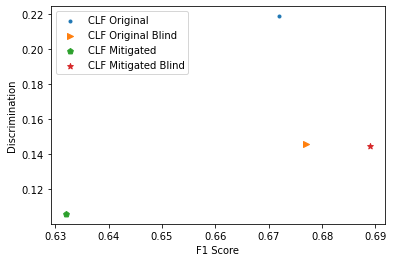

In [35]:
plotDisc(res)

In [36]:
FATInput=DataDescription(X_test,y_test,class_names,column_names,protected,protected_feature)

The grouping based on the *races* feature has the following distribution:
    * "('race_African-American',)" grouping has 152 instances.
    * "('race_Asian',)" grouping has 1 instances.
    * "('race_Caucasian',)" grouping has 105 instances.
    * "('race_Hispanic',)" grouping has 32 instances.
    * "('race_Other',)" grouping has 10 instances.

The class distribution per sub-population:
    * For the "('race_African-American',)" grouping the classes are distributed as follows:
        - The class *Medium-Low* has 98 data points.
        - The class *High* has 54 data points.
    * For the "('race_Asian',)" grouping the classes are distributed as follows:
        - The class *Medium-Low* has 1 data points.
    * For the "('race_Caucasian',)" grouping the classes are distributed as follows:
        - The class *Medium-Low* has 93 data points.
        - The class *High* has 12 data points.
    * For the "('race_Hispanic',)" grouping the classes are distributed as follows:
        - The 

In [37]:
resDisparateImp=disparateImpactMetrics(clfs,FATInput,X_test,X_test_blind,y_test,protected_feature)
resDisparateImp

Some of the given labels are not present in either of the input arrays: {1}.
Some of the given labels are not present in either of the input arrays: {1}.


The *Equal Accuracy* group-based fairness metric for *races* feature split are:
The *Equal Opportunity* group-based fairness metric for *races* feature split are:
The *Demographic Parity* group-based fairness metric for *races* feature split are:
The *Equal Accuracy* group-based fairness metric for *races* feature split are:
    *  NOT  satisfied for "('race_African-American',)" and "('race_Asian',)" sub-populations.
    *  NOT  satisfied for "('race_African-American',)" and "('race_Other',)" sub-populations.
The *Equal Opportunity* group-based fairness metric for *races* feature split are:
The *Demographic Parity* group-based fairness metric for *races* feature split are:


Some of the given labels are not present in either of the input arrays: {1}.


The *Equal Accuracy* group-based fairness metric for *races* feature split are:
    *  NOT  satisfied for "('race_African-American',)" and "('race_Asian',)" sub-populations.
    *  NOT  satisfied for "('race_African-American',)" and "('race_Other',)" sub-populations.
The *Equal Opportunity* group-based fairness metric for *races* feature split are:
The *Demographic Parity* group-based fairness metric for *races* feature split are:
    *  NOT  satisfied for "('race_African-American',)" and "('race_Asian',)" sub-populations.
    *  NOT  satisfied for "('race_African-American',)" and "('race_Other',)" sub-populations.
The *Equal Accuracy* group-based fairness metric for *races* feature split are:
The *Equal Opportunity* group-based fairness metric for *races* feature split are:
The *Demographic Parity* group-based fairness metric for *races* feature split are:
    *  NOT  satisfied for "('race_African-American',)" and "('race_Asian',)" sub-populations.
    *  NOT  satisfied for "('race_Af

Some of the given labels are not present in either of the input arrays: {1}.


{'Equal Accuracy': {'Delta O-OB': ["'race_African-American' 'race_Asian' ",
   "'race_African-American' 'race_Other' "],
  'Delta M-MB': ["'race_African-American' 'race_Asian' ",
   "'race_African-American' 'race_Other' "],
  'Delta O-M': ["'race_African-American' 'race_Asian' ",
   "'race_African-American' 'race_Other' "],
  'Delta OB-MB': ["'race_African-American' 'race_Asian' ",
   "'race_African-American' 'race_Other' "]},
 'Equal Opportunity': {'Delta O-OB': [],
  'Delta M-MB': [],
  'Delta O-M': [],
  'Delta OB-MB': []},
 'Demographic Parity': {'Delta O-OB': [],
  'Delta M-MB': ["'race_African-American' 'race_Hispanic' "],
  'Delta O-M': ["'race_African-American' 'race_Asian' ",
   "'race_African-American' 'race_Other' "],
  'Delta OB-MB': ["'race_African-American' 'race_Asian' ",
   "'race_African-American' 'race_Other' ",
   "'race_African-American' 'race_Hispanic' "]}}

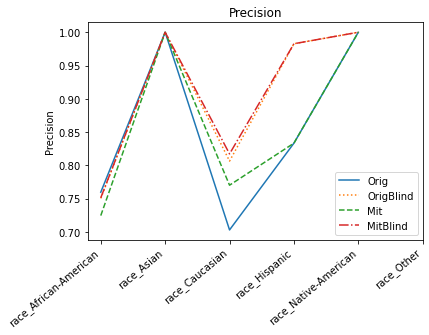

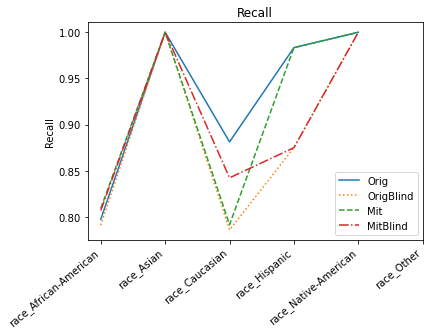

In [38]:
standardMetricsPerGroup(clfs,column_names,target,X_test,y_test,protected_feature,protected)

#### XAI Fixed Reference Set

##### SHAP Kernel Explainer

In [39]:
shap_v = SHAP(clfs,column_names,X_train,X_train_mod,X_test,protected,changeReferenceSet=False,Tree=False)  
XAISum,XAIMean = deltas(shap_v,column_names)
resSHAP = buildFinalResXAI(XAISum,XAIMean,protected,non_sensitive)

In [40]:
PIK = "US_RF_SHAPV_Fix.dat"
with open(path_res+"/"+PIK, "wb") as f:
  pickle.dump(shap_v, f)

In [9]:
PIK = "US_RF_SHAPV_Fix.dat"
with open(path_res+"/"+PIK, "rb") as f:
  shap_v = pickle.load(f)

In [10]:
XAISum,XAIMean = deltas(shap_v,column_names)
XAISum

Empty DataFrame
Columns: []
Index: []

In [11]:
XAIMean

clfOrig-clfOrigBlind  clfMit-clfMitBlind  \
age                                  0.024755            0.027292   
sex                                  0.000687            0.001479   
priors_count                         0.025291            0.029774   
days_b_screening_arrest              0.003493            0.006492   
c_charge_degree                      0.002205            0.003438   
is_recid                             0.005854            0.009319   
is_violent_recid                     0.001198            0.001666   
two_year_recid                       0.005769            0.007517   
length_of_stay                       0.010121            0.011900   
race_African-American                0.045848            0.005215   
race_Asian                           0.000023            0.000045   
race_Caucasian                       0.011160            0.009173   
race_Hispanic                        0.002261            0.003212   
race_Native-American                 0.000000            0.000000   
race_Other                           0.001248            0.002027   

                         clfOrig-clfMit  clfOrigBlind-clfMitBlind  
age                            0.009161                  0.012679  
sex                            0.000706                  0.001348  
priors_count                   0.007639                  0.013290  
days_b_screening_arrest        0.004028                  0.007141  
c_charge_degree                0.003353                  0.002445  
is_recid                       0.006792                  0.012018  
is_violent_recid               0.001436                  0.001874  
two_year_recid                 0.014006                  0.015515  
length_of_stay                 0.009461                  0.015154  
race_African-American          0.041332                  0.000000  
race_Asian                     0.000015                  0.000007  
race_Caucasian                 0.019853                  0.000000  
race_Hispanic                  0.001117                  0.000000  
race_Native-American           0.000000                  0.000000  
race_Other                     0.000779                  0.000000

In [12]:
EValues = computeE(shap_v,column_names)
EValues 

E
clfOrig-clfOrigBlind      0.009
clfMit-clfMitBlind        0.008
clfOrig-clfMit            0.008
clfOrigBlind-clfMitBlind  0.005

In [14]:
resSHAP = pd.read_csv(path_res+'US_RF_ResSHAP_Fix.csv',index_col=0)
resSHAP.to_csv(path_or_buf=path_res+'US_RF_ResSHAP_Fix.csv')
resSHAP

clfOrig-clfOrigBlind  clfMit-clfMitBlind  clfOrig-clfMit  \
SA-Sum                   0.930               0.661           1.075   
SA-Mean                  0.010               0.003           0.011   
NSA-Sum                 15.146              14.699          13.864   
NSA-Mean                 0.010               0.011           0.006   

          clfOrigBlind-clfMitBlind  
SA-Sum                       0.000  
SA-Mean                      0.000  
NSA-Sum                     15.981  
NSA-Mean                     0.008

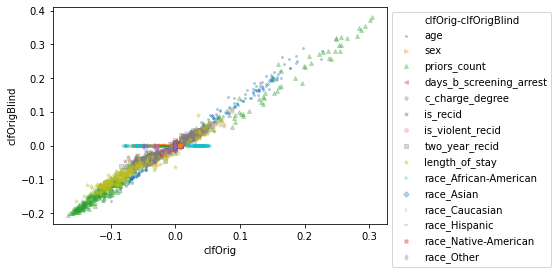

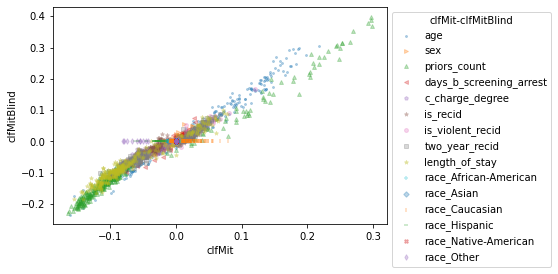

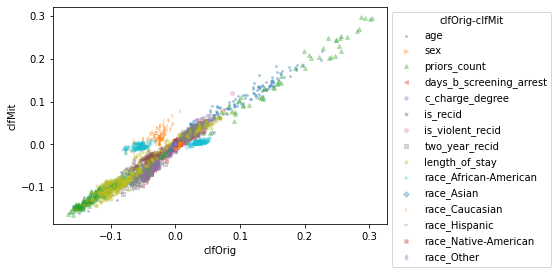

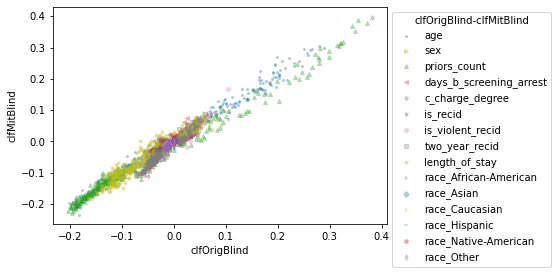

In [48]:
XAIPlots(shap_v,column_names,diffClfs=True)

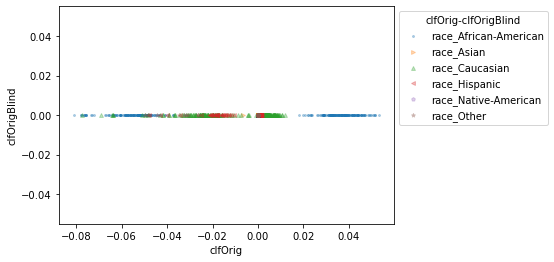

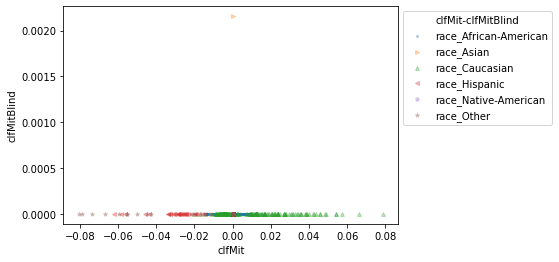

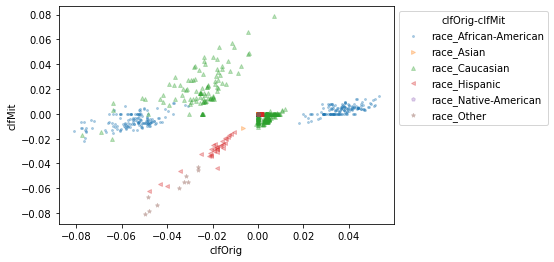

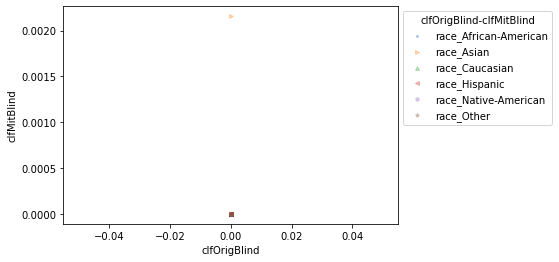

In [49]:
XAIPlots(shap_v,protected,diffClfs=True)

##### SHAP Explainer 4 Trees

In [ ]:
shap_v = SHAP(clfs,column_names,X_train,X_train_mod,X_test,protected,changeReferenceSet=False,Tree=True)  
XAISum,XAIMean = deltas(shap_v,column_names)
resSHAP = buildFinalResXAI(XAISum,XAIMean,protected,non_sensitive)

In [ ]:
PIK = "US_RF_SHAPV_Fix_Tree.dat"
with open(path_res+"/"+PIK, "wb") as f:
  pickle.dump(shap_v, f)

In [ ]:
PIK = "US_RF_SHAPV_Fix_Tree.dat"
with open(path_res+"/"+PIK, "rb") as f:
  shap_v = pickle.load(f)

In [ ]:
XAISum,XAIMean = deltas(shap_v,column_names)
XAISum

In [ ]:
XAIMean

In [ ]:
EValues = computeE(shap_v,column_names)
EValues 

In [ ]:
resSHAP = pd.read_csv(path_res+'US_RF_ResSHAP_Fix_Tree.csv',index_col=0)
resSHAP = resSHAP.round(3)
resSHAP.to_csv(path_or_buf=path_res+'US_RF_ResSHAP_Fix_Tree.csv')
resSHAP

In [ ]:
XAIPlots(shap_v,column_names,diffClfs=True)

In [ ]:
XAIPlots(shap_v,protected,diffClfs=True)

##### LIME

In [ ]:
lime_v= LIME(clfs,column_names,class_names,X_train,X_train_mod,X_test,protected,changeReferenceSet=False)
XAISum,XAIMean = deltas(lime_v,column_names)
resLIME = buildFinalResXAI(XAISum,XAIMean,protected,non_sensitive)

In [ ]:
PIK = "US_RF_LIMEV_Fix.dat"
with open(path_res+"/"+PIK, "wb") as f:
  pickle.dump(lime_v, f)

In [ ]:
PIK = "US_RF_LIMEV_Fix.dat"
with open(path_res+"/"+PIK, "rb") as f:
  lime_v = pickle.load(f)

In [ ]:
XAISum,XAIMean = deltas(lime_v,column_names)
XAISum

In [ ]:
XAIMean

In [ ]:
EValues = computeE(lime_v,column_names)
EValues 

In [ ]:
resLIME = pd.read_csv(path_res+'US_RF_ResLIME_Fix.csv',index_col=0)
resLIME = resLIME.round(3)
resLIME.to_csv(path_or_buf=path_res+'US_RF_ResLIME_Fix.csv')
resLIME

In [ ]:
XAIPlots(lime_v,column_names,diffClfs=True)

In [ ]:
XAIPlots(lime_v,protected,diffClfs=True)

#### XAI Changing Reference Set

##### SHAP Kernel Explainer

In [ ]:
shap_v = SHAP(clfs,column_names,X_train,X_train_mod,X_test,protected,changeReferenceSet=True,Tree=False)  
XAISum,XAIMean = deltas(shap_v,column_names)
resSHAP = buildFinalResXAI(XAISum,XAIMean,protected,non_sensitive)

In [ ]:
PIK = "US_RF_SHAPV_Change.dat"
with open(path_res+"/"+PIK, "wb") as f:
  pickle.dump(shap_v, f)

In [ ]:
PIK = "US_RF_SHAPV_Change.dat"
with open(path_res+"/"+PIK, "rb") as f:
  shap_v = pickle.load(f)

In [ ]:
XAISum,XAIMean = deltas(shap_v,column_names)
XAISum

In [ ]:
XAIMean

In [ ]:
EValues = computeE(shap_v,column_names)
EValues 

In [ ]:
resSHAP = pd.read_csv(path_res+'US_RF_ResSHAP_Change.csv',index_col=0)
resSHAP = resSHAP.round(3)
resSHAP.to_csv(path_or_buf=path_res+'US_RF_ResSHAP_Change.csv')
resSHAP

In [ ]:
XAIPlots(shap_v,column_names,diffClfs=True)

In [ ]:
XAIPlots(shap_v,protected,diffClfs=True)

##### SHAP Explainer 4 Trees

In [ ]:
shap_v = SHAP(clfs,column_names,X_train,X_train_mod,X_test,protected,changeReferenceSet=True,Tree=True)  
XAISum,XAIMean = deltas(shap_v,column_names)
resSHAP = buildFinalResXAI(XAISum,XAIMean,protected,non_sensitive)

In [ ]:
PIK = "US_RF_SHAPV_Change_Tree.dat"
with open(path_res+"/"+PIK, "wb") as f:
  pickle.dump(shap_v, f)

In [ ]:
PIK = "US_RF_SHAPV_Change_Tree.dat"
with open(path_res+"/"+PIK, "rb") as f:
  shap_v = pickle.load(f)

In [ ]:
XAISum,XAIMean = deltas(shap_v,column_names)
XAISum

In [ ]:
XAIMean

In [ ]:
EValues = computeE(shap_v,column_names)
EValues 

In [ ]:
resSHAP = pd.read_csv(path_res+'US_RF_ResSHAP_Change_Tree.csv',index_col=0)
resSHAP = resSHAP.round(3)
resSHAP.to_csv(path_or_buf=path_res+'US_RF_ResSHAP_Change_Tree.csv')
resSHAP

In [ ]:
XAIPlots(shap_v,column_names,diffClfs=True)

In [ ]:
XAIPlots(shap_v,protected,diffClfs=True)

##### LIME

In [ ]:
lime_v= LIME(clfs,column_names,class_names,X_train,X_train_mod,X_test,protected,changeReferenceSet=True)
XAISum,XAIMean = deltas(lime_v,column_names)
resLIME = buildFinalResXAI(XAISum,XAIMean,protected,non_sensitive)

In [ ]:
PIK = "US_RF_LIMEV_Change.dat"
with open(path_res+"/"+PIK, "wb") as f:
  pickle.dump(lime_v, f)

In [ ]:
PIK = "US_RF_LIMEV_Change.dat"
with open(path_res+"/"+PIK, "rb") as f:
  lime_v = pickle.load(f)

In [ ]:
XAISum,XAIMean = deltas(lime_v,column_names)
XAISum

In [ ]:
XAIMean

In [ ]:
EValues = computeE(lime_v,column_names)
EValues 

In [ ]:
resLIME = pd.read_csv(path_res+'US_RF_ResLIME_Change.csv',index_col=0)
resLIME = resLIME.round(3)
resLIME.to_csv(path_or_buf=path_res+'US_RF_ResLIME_Change.csv')
resLIME

In [ ]:
XAIPlots(lime_v,column_names,diffClfs=True)

In [ ]:
XAIPlots(lime_v,protected,diffClfs=True)

#### Comparison

##### SHAP Kernel Explainer

In [ ]:
PIK = "US_RF_SHAPV_Fix.dat"
with open(path_res+"/"+PIK, "rb") as f:
  shap_v_fix = pickle.load(f)

In [ ]:
PIK = "US_RF_SHAPV_Change.dat"
with open(path_res+"/"+PIK, "rb") as f:
  shap_v_change = pickle.load(f)

In [ ]:
XAISum,XAIMean = deltas(shap_v_fix,column_names,False,shap_v_change)
XAISum

In [ ]:
XAIMean

In [ ]:
resSHAP = buildFinalResXAI(XAISum,XAIMean,protected,non_sensitive)
resSHAP = resSHAP.round(3)
resSHAP

In [ ]:
XAIPlots(shap_v_fix,protected,True,shap_v_change)

##### SHAP Explainer 4 Trees

In [ ]:
PIK = "US_RF_SHAPV_Fix_Tree.dat"
with open(path_res+"/"+PIK, "rb") as f:
  shap_v_fix = pickle.load(f)

In [ ]:
PIK = "US_RF_SHAPV_Change_Tree.dat"
with open(path_res+"/"+PIK, "rb") as f:
  shap_v_change = pickle.load(f)

In [ ]:
XAISum,XAIMean = deltas(shap_v_fix,column_names,False,shap_v_change)
XAISum

In [ ]:
XAIMean

In [ ]:
resSHAP = buildFinalResXAI(XAISum,XAIMean,protected,non_sensitive)
resSHAP = resSHAP.round(3)
resSHAP

In [ ]:
XAIPlots(shap_v_fix,protected,True,shap_v_change)

##### LIME

In [ ]:
PIK = "US_RF_LIMEV_Fix.dat"
with open(path_res+"/"+PIK, "rb") as f:
  lime_v_fix = pickle.load(f)

In [ ]:
PIK = "US_RF_LIMEV_Change.dat"
with open(path_res+"/"+PIK, "rb") as f:
  lime_v_change = pickle.load(f)

In [ ]:
XAISum,XAIMean = deltas(lime_v_fix,column_names,False,lime_v_change)
XAISum

In [ ]:
XAIMean

In [ ]:
resLIME = buildFinalResXAI(XAISum,XAIMean,protected,non_sensitive)
resLIME = resLIME.round(3)
resLIME

In [ ]:
XAIPlots(lime_v_fix,protected,True,lime_v_change)

## Preferential Sampling

In [ ]:
filename = 'compas-scores-two-years.csv'
path_data = 'datasets/'
path_res = '/Users/Marta/FAccT/Res-COMPAS/'
sensitive = ['race'] #OR sex
df = prepare_compass_dataset(filename, path_data, sensitive)
df

In [ ]:
target = 'target'
column_names = df.columns.values.tolist()
column_names.remove(target)
class_names=['Medium-Low','High']
adClass=0
disClass=1
protected = ['race_African-American','race_Asian','race_Caucasian','race_Hispanic','race_Native-American','race_Other']
protected_feature='races' 
non_sensitive = [elem for elem in column_names if elem not in protected]
adAttr=None#'race_Caucasian'
disAttr=None#'race_African-American'

In [ ]:
X,Y,X_blind,X_train,X_test,y_train,y_test,df=prepare_for_sampling(df,protected)

In [6]:
X=X.reset_index()
X=X.drop(['index'], 1) 
X = X.sample(3000)
X_blind = X_blind.iloc[X.index]
Y = Y[X.index]

In [ ]:
X_test = pd.DataFrame(X_test, columns=column_names)
X_test = X_test.sample(300)
y_test = y_test[X_test.index]
X_test = X_test.values

In [7]:
blind,ranker = rankers(X,X_blind,Y)

Non-Blind Rankers
GaussianNB(var_smoothing=0.004328761281083057)
LogisticRegression(C=0.615848211066026, penalty='l1', solver='liblinear')
RandomForestClassifier(bootstrap=False, max_depth=8, max_features='log2',
                       n_estimators=500)


The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.


SVC(C=1, gamma=0.1, probability=True)
Non-Blind Rankers Evaluation
           Gaussian Naive Bayes  Calibrated Gaussian Naive Bayes  \
Accuracy               0.779333                         0.780667   
Precision              0.697725                         0.700830   
Recall                 0.256037                         0.263821   
F1 Score               0.372767                         0.381644   

           Logistic Regression  Calibrated Logistic Regression  Random Forest  \
Accuracy              0.815667                        0.814333       0.809333   
Precision             0.714273                        0.718552       0.712733   
Recall                0.478626                        0.463092       0.436020   
F1 Score              0.571194                        0.560653       0.540375   

           Calibrated Random Forest  Support Vector Classifier  \
Accuracy                   0.813000                   0.782000   
Precision                  0.704091                   

The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.


SVC(C=1, gamma=0.1, probability=True)
Blind Rankers Evaluation
           Blind Gaussian Naive Bayes  Blind Calibrated Gaussian Naive Bayes  \
Accuracy                     0.783333                               0.791000   
Precision                    0.598333                               0.643448   
Recall                       0.483888                               0.423075   
F1 Score                     0.533936                               0.509761   

           Blind Logistic Regression  Blind Calibrated Logistic Regression  \
Accuracy                    0.817333                              0.815000   
Precision                   0.728093                              0.727741   
Recall                      0.465723                              0.451487   
F1 Score                    0.566835                              0.556215   

           Blind Random Forest  Blind Calibrated Random Forest  \
Accuracy              0.810333                        0.811000   
Precision    

In [52]:

PIK = "Ranker.dat"
with open(path_res+"/"+PIK, "wb") as f:
  pickle.dump(ranker, f)

In [53]:
PIK = "Ranker.dat"
with open(path_res+"/"+PIK, "rb") as f:
  ranker = pickle.load(f)

In [54]:
df_new=PreferentialSampling(target,protected,ranker,blind,df,adClass,disClass,adAttr,disAttr)

Counting labels = 0  {'race_African-American': 1381, 'race_Asian': 22, 'race_Caucasian': 1244, 'race_Hispanic': 300, 'race_Native-American': 3, 'race_Other': 222}
Counting labels = 1  {'race_African-American': 838, 'race_Asian': 3, 'race_Caucasian': 231, 'race_Hispanic': 45, 'race_Native-American': 6, 'race_Other': 25}
DN  ('race_African-American', 838)
FP  ('race_Caucasian', 1244)
DP  ('race_African-American', 1381)
FN  ('race_Caucasian', 231)
Len DN_df  838
Len FP_df  1244
Len DP_df  1381
Len FN_df  231


elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


Len restData 626
DN_expected  642
196 to be removed
Len DN_df after sampling  642
FP_expected  1048
196 to be removed
Len FP_df after sampling  1048
DP_expected  1577
196 to add
Len DP_df after sampling  1577
FN_expected  427
196 to add
Len FN_df after sampling  427


In [55]:
findFreq(target,protected,df_new)

({'race_African-American': 1577,
  'race_Asian': 22,
  'race_Caucasian': 1048,
  'race_Hispanic': 300,
  'race_Native-American': 3,
  'race_Other': 222},
 {'race_African-American': 642,
  'race_Asian': 3,
  'race_Caucasian': 427,
  'race_Hispanic': 45,
  'race_Native-American': 6,
  'race_Other': 25})

In [9]:
X_train,X_train_blind,X_train_mod,X_train_mod_blind,y_train_mod,X_test,X_test_blind=prepare_for_classification(df_new,X_train,X_test,column_names,protected,True)

### MLP

In [10]:

clf = MLPClassifier()
param_grid = dict(hidden_layer_sizes=[(50, 50, 50), (50, 100, 50)],
                          activation=['tanh', 'relu'],
                          solver=['sgd', 'adam'],
                          alpha=[0.0001, 0.05],
                          learning_rate=['constant', 'adaptive']
                          )

In [11]:

clfOrig,clfOrigBlind,clfMit,clfMitBlind,res = Classifiers(clf,param_grid,target,column_names,X_train,X_train_mod,X_train_blind,X_train_mod_blind,y_train,y_train_mod,X_test,X_test_blind,y_test,protected,adClass,disClass,adAttr,disAttr)
res.to_csv(path_or_buf=path_res+'PS_MLP_Performances.csv')
res

Original Train Dimension = 4320
Mitigated Train Dimension = 4320
Test Dimension = 300


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer

---> CLF Original: 
Favoured attribute value: [ race_Caucasian ] Freq.: [ 105 ] Labeled as + class: [ 100 ]
Unfavoured attribute value: [ race_African-American ] Freq.: [ 149 ] Labeled as + class: [ 106 ]
---> CLF Mitigated: 
Favoured attribute value: [ race_Caucasian ] Freq.: [ 105 ] Labeled as + class: [ 73 ]
Unfavoured attribute value: [ race_African-American ] Freq.: [ 149 ] Labeled as + class: [ 117 ]
---> CLF Original Blind: 
Favoured attribute value: [ race_Caucasian ] Freq.: [ 105 ] Labeled as + class: [ 88 ]
Unfavoured attribute value: [ race_African-American ] Freq.: [ 149 ] Labeled as + class: [ 107 ]
---> CLF Mitigated Blind: 
Favoured attribute value: [ race_Caucasian ] Freq.: [ 105 ] Labeled as + class: [ 90 ]
Unfavoured attribute value: [ race_African-American ] Freq.: [ 149 ] Labeled as + class: [ 107 ]


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


CLF Original  CLF Original Blind  CLF Mitigated  \
F1 Score            0.565217            0.604027       0.571429   
Discrimination      0.240972            0.119974      -0.089997   

                CLF Mitigated Blind           Best Score  Delta O-OB  \
F1 Score                   0.621622  CLF Mitigated Blind    0.038809   
Discrimination             0.139022        CLF Mitigated    0.120997   

                Delta M-MB  Delta O-M  Delta OB-MB  
F1 Score          0.050193   0.006211     0.017595  
Discrimination    0.229019   0.330968     0.019048

In [59]:

PIK = "PS_Clfs_MLP.dat"
with open(path_res+"/"+PIK, "wb") as f:
  pickle.dump([clfOrig,clfOrigBlind,clfMit,clfMitBlind], f)

In [60]:
PIK = "PS_Clfs_MLP.dat"
with open(path_res+"/"+PIK, "rb") as f:
  clfOrig,clfOrigBlind,clfMit,clfMitBlind = pickle.load(f)
clfs={'clfOrig':clfOrig,'clfOrigBlind':clfOrigBlind,'clfMit':clfMit,'clfMitBlind':clfMitBlind}

In [61]:
res = pd.read_csv(path_res+'PS_MLP_Performances.csv',index_col=0)
res = res.round(3)
res.to_csv(path_res+'PS_MLP_Performances.csv')
res

CLF Original  CLF Original Blind  CLF Mitigated  \
F1 Score               0.677               0.641          0.571   
Discrimination         0.204               0.123         -0.040   

                CLF Mitigated Blind     Best Score  Delta O-OB  Delta M-MB  \
F1 Score                      0.667   CLF Original       0.036       0.095   
Discrimination                0.205  CLF Mitigated       0.081       0.245   

                Delta O-M  Delta OB-MB  
F1 Score            0.105        0.026  
Discrimination      0.244        0.082

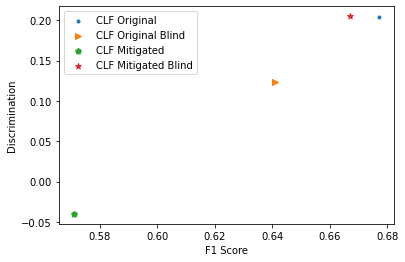

In [62]:
plotDisc(res)

In [63]:
FATInput=DataDescription(X_test,y_test,class_names,column_names,protected,protected_feature)

The grouping based on the *races* feature has the following distribution:
    * "('race_African-American',)" grouping has 152 instances.
    * "('race_Asian',)" grouping has 1 instances.
    * "('race_Caucasian',)" grouping has 105 instances.
    * "('race_Hispanic',)" grouping has 32 instances.
    * "('race_Other',)" grouping has 10 instances.

The class distribution per sub-population:
    * For the "('race_African-American',)" grouping the classes are distributed as follows:
        - The class *Medium-Low* has 98 data points.
        - The class *High* has 54 data points.
    * For the "('race_Asian',)" grouping the classes are distributed as follows:
        - The class *Medium-Low* has 1 data points.
    * For the "('race_Caucasian',)" grouping the classes are distributed as follows:
        - The class *Medium-Low* has 93 data points.
        - The class *High* has 12 data points.
    * For the "('race_Hispanic',)" grouping the classes are distributed as follows:
        - The 

In [64]:
resDisparateImp=disparateImpactMetrics(clfs,FATInput,X_test,X_test_blind,y_test,protected_feature)
resDisparateImp

The *Equal Accuracy* group-based fairness metric for *races* feature split are:
    *  NOT  satisfied for "('race_African-American',)" and "('race_Asian',)" sub-populations.
    *  NOT  satisfied for "('race_African-American',)" and "('race_Hispanic',)" sub-populations.
    *  NOT  satisfied for "('race_African-American',)" and "('race_Other',)" sub-populations.
The *Equal Opportunity* group-based fairness metric for *races* feature split are:
The *Demographic Parity* group-based fairness metric for *races* feature split are:
The *Equal Accuracy* group-based fairness metric for *races* feature split are:
    *  NOT  satisfied for "('race_African-American',)" and "('race_Asian',)" sub-populations.
    *  NOT  satisfied for "('race_African-American',)" and "('race_Other',)" sub-populations.
The *Equal Opportunity* group-based fairness metric for *races* feature split are:
The *Demographic Parity* group-based fairness metric for *races* feature split are:
    *  NOT  satisfied for "('race

Some of the given labels are not present in either of the input arrays: {1}.
Some of the given labels are not present in either of the input arrays: {1}.
Some of the given labels are not present in either of the input arrays: {1}.
Some of the given labels are not present in either of the input arrays: {1}.


{'Equal Accuracy': {'Delta O-OB': ["'race_African-American' 'race_Hispanic' "],
  'Delta M-MB': [],
  'Delta O-M': ["'race_African-American' 'race_Hispanic' "],
  'Delta OB-MB': []},
 'Equal Opportunity': {'Delta O-OB': [],
  'Delta M-MB': [],
  'Delta O-M': [],
  'Delta OB-MB': []},
 'Demographic Parity': {'Delta O-OB': ["'race_African-American' 'race_Asian' ",
   "'race_African-American' 'race_Other' ",
   "'race_African-American' 'race_Hispanic' "],
  'Delta M-MB': ["'race_African-American' 'race_Asian' ",
   "'race_African-American' 'race_Other' ",
   "'race_African-American' 'race_Hispanic' "],
  'Delta O-M': ["'race_African-American' 'race_Asian' ",
   "'race_African-American' 'race_Other' ",
   "'race_African-American' 'race_Hispanic' "],
  'Delta OB-MB': ["'race_African-American' 'race_Asian' ",
   "'race_African-American' 'race_Other' ",
   "'race_African-American' 'race_Hispanic' "]}}

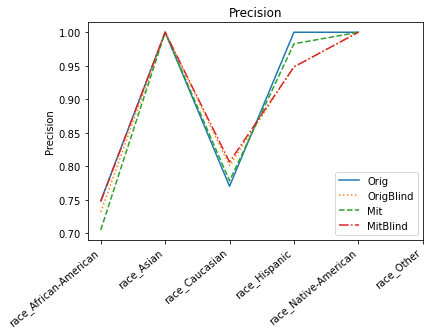

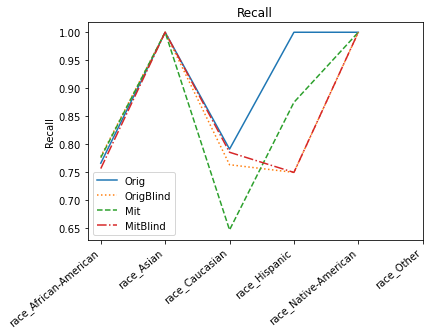

In [65]:
standardMetricsPerGroup(clfs,column_names,target,X_test,y_test,protected_feature,protected)

#### XAI Fixed Reference Set

##### SHAP Kernel Explainer

In [14]:
shap_v = SHAP(clfs,column_names,X_train,X_train_mod,X_test,protected,changeReferenceSet=False,Tree=False)  
XAISum,XAIMean = deltas(shap_v,column_names)
resSHAP = buildFinalResXAI(XAISum,XAIMean,protected,non_sensitive)

In [15]:
PIK = "PS_MLP_SHAPV_Fix.dat"
with open(path_res+"/"+PIK, "wb") as f:
  pickle.dump(shap_v, f)

In [16]:
PIK = "PS_MLP_SHAPV_Fix.dat"
with open(path_res+"/"+PIK, "rb") as f:
  shap_v = pickle.load(f)

In [17]:
XAISum,XAIMean = deltas(shap_v,column_names)
XAISum

Empty DataFrame
Columns: []
Index: []

In [18]:
XAIMean

clfOrig-clfOrigBlind  clfMit-clfMitBlind  \
age                                  0.032406            0.046739   
sex                                  0.005306            0.007812   
priors_count                         0.017732            0.068884   
days_b_screening_arrest              0.011827            0.012964   
c_charge_degree                      0.003541            0.008038   
is_recid                             0.006219            0.008235   
is_violent_recid                     0.005130            0.006191   
two_year_recid                       0.003282            0.008879   
length_of_stay                       0.021505            0.038331   
race_African-American                0.020607            0.017268   
race_Asian                           0.000000            0.000157   
race_Caucasian                       0.014187            0.078516   
race_Hispanic                        0.003541            0.002265   
race_Native-American                 0.000064            0.000403   
race_Other                           0.000348            0.001493   

                         clfOrig-clfMit  clfOrigBlind-clfMitBlind  
age                            0.056748                  0.022984  
sex                            0.011886                  0.001577  
priors_count                   0.052457                  0.033980  
days_b_screening_arrest        0.012408                  0.012496  
c_charge_degree                0.007705                  0.004451  
is_recid                       0.009960                  0.003817  
is_violent_recid               0.006073                  0.005616  
two_year_recid                 0.011817                  0.014658  
length_of_stay                 0.028739                  0.035373  
race_African-American          0.037702                  0.000000  
race_Asian                     0.000157                  0.000000  
race_Caucasian                 0.092704                  0.000000  
race_Hispanic                  0.003739                  0.000004  
race_Native-American           0.000347                  0.000018  
race_Other                     0.001175                  0.000000

In [19]:
EValues = computeE(shap_v,column_names)
EValues 

E
clfOrig-clfOrigBlind      0.010
clfMit-clfMitBlind        0.020
clfOrig-clfMit            0.022
clfOrigBlind-clfMitBlind  0.009

In [20]:
resSHAP = buildFinalResXAI(XAISum,XAIMean,protected,non_sensitive)
resSHAP = resSHAP.round(3)
resSHAP.to_csv(path_or_buf=path_res+'PS_MLP_ResSHAP_Fix.csv')
resSHAP

clfOrig-clfOrigBlind  clfMit-clfMitBlind  clfOrig-clfMit  \
SA-Mean                  0.006               0.017           0.023   
SA-Sd                    0.008               0.028           0.034   
NSA-Mean                 0.012               0.023           0.022   
NSA-Sd                   0.010               0.021           0.019   

          clfOrigBlind-clfMitBlind  
SA-Mean                      0.000  
SA-Sd                        0.000  
NSA-Mean                     0.015  
NSA-Sd                       0.012

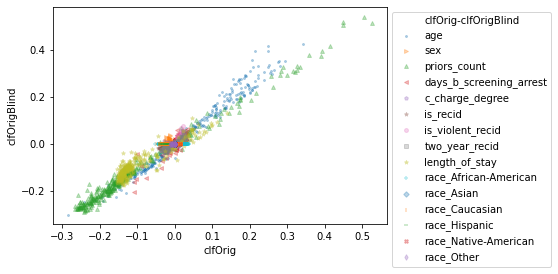

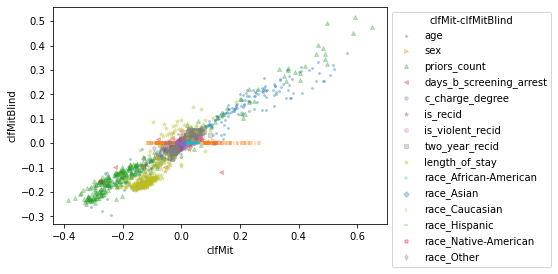

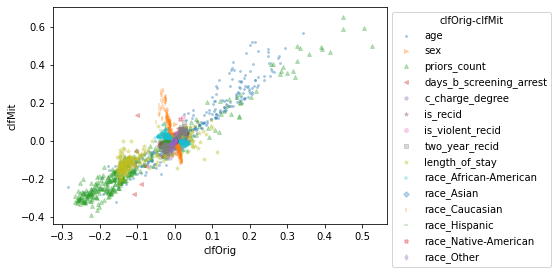

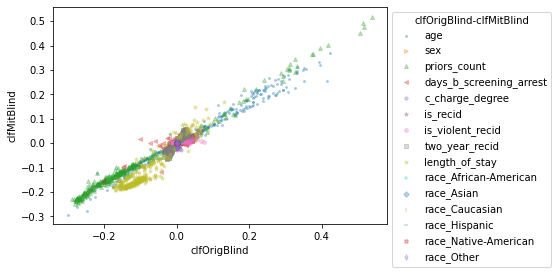

In [21]:
XAIPlots(shap_v,column_names,diffClfs=True)

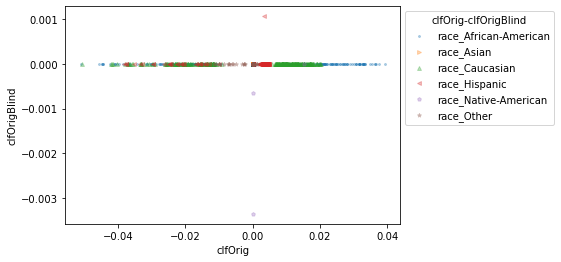

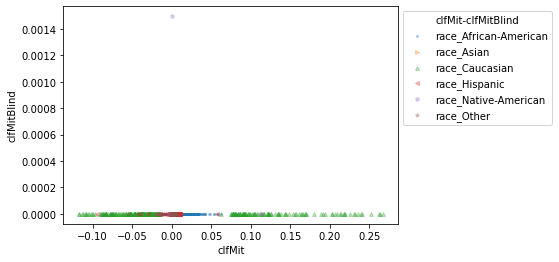

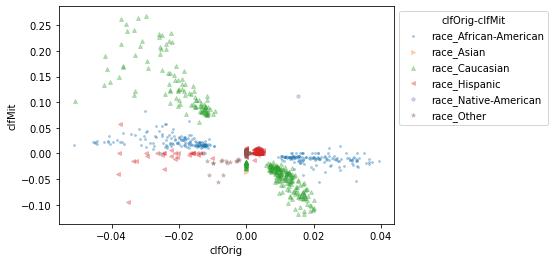

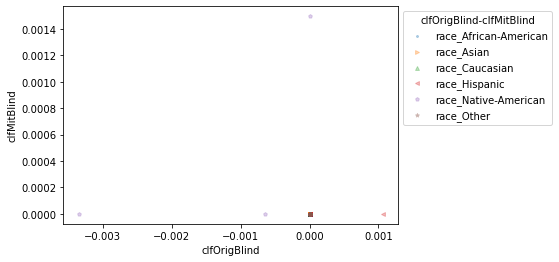

In [22]:
XAIPlots(shap_v,protected,diffClfs=True)

##### LIME

In [23]:
lime_v= LIME(clfs,column_names,class_names,X_train,X_train_mod,X_test,protected,changeReferenceSet=False)
XAISum,XAIMean = deltas(lime_v,column_names)
resLIME = buildFinalResXAI(XAISum,XAIMean,protected,non_sensitive)

In [24]:
PIK = "PS_MLP_LIMEV_Fix.dat"
with open(path_res+"/"+PIK, "wb") as f:
  pickle.dump(lime_v, f)

In [25]:
PIK = "PS_MLP_LIMEV_Fix.dat"
with open(path_res+"/"+PIK, "rb") as f:
  lime_v = pickle.load(f)

In [26]:
XAISum,XAIMean = deltas(lime_v,column_names)
XAISum

Empty DataFrame
Columns: []
Index: []

In [27]:
XAIMean

clfOrig-clfOrigBlind  clfMit-clfMitBlind  \
age                                  0.047371            0.059692   
sex                                  0.010105            0.011256   
priors_count                         0.019357            0.054983   
days_b_screening_arrest              0.011139            0.020779   
c_charge_degree                      0.009842            0.011536   
is_recid                             0.009903            0.010984   
is_violent_recid                     0.008586            0.011623   
two_year_recid                       0.008867            0.010972   
length_of_stay                       0.020682            0.029158   
race_African-American                0.018796            0.016655   
race_Asian                           0.007850            0.009219   
race_Caucasian                       0.014996            0.055222   
race_Hispanic                        0.009109            0.009575   
race_Native-American                 0.009048            0.012646   
race_Other                           0.007917            0.009053   

                         clfOrig-clfMit  clfOrigBlind-clfMitBlind  
age                            0.066319                  0.038872  
sex                            0.013158                  0.008395  
priors_count                   0.036263                  0.035760  
days_b_screening_arrest        0.015051                  0.017492  
c_charge_degree                0.011197                  0.009992  
is_recid                       0.012699                  0.009281  
is_violent_recid               0.010515                  0.010269  
two_year_recid                 0.011847                  0.010385  
length_of_stay                 0.034771                  0.031249  
race_African-American          0.032568                  0.009482  
race_Asian                     0.009694                  0.008138  
race_Caucasian                 0.068591                  0.009655  
race_Hispanic                  0.009909                  0.008613  
race_Native-American           0.012612                  0.010243  
race_Other                     0.009796                  0.008987

In [28]:
EValues = computeE(lime_v,column_names)
EValues 

E
clfOrig-clfOrigBlind      0.014
clfMit-clfMitBlind        0.022
clfOrig-clfMit            0.024
clfOrigBlind-clfMitBlind  0.015

In [29]:
resLIME = buildFinalResXAI(XAISum,XAIMean,protected,non_sensitive)
resLIME = resLIME.round(3)
resLIME.to_csv(path_or_buf=path_res+'PS_MLP_ResLIME_Fix.csv')
resLIME

clfOrig-clfOrigBlind  clfMit-clfMitBlind  clfOrig-clfMit  \
SA-Mean                  0.011               0.019           0.024   
SA-Sd                    0.004               0.017           0.022   
NSA-Mean                 0.016               0.025           0.024   
NSA-Sd                   0.012               0.018           0.018   

          clfOrigBlind-clfMitBlind  
SA-Mean                      0.009  
SA-Sd                        0.001  
NSA-Mean                     0.019  
NSA-Sd                       0.012

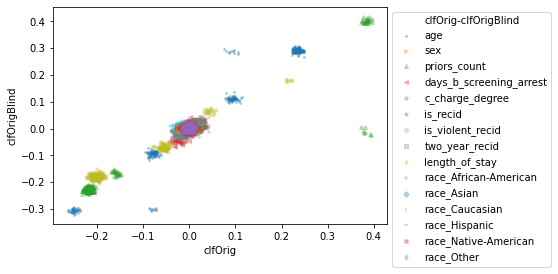

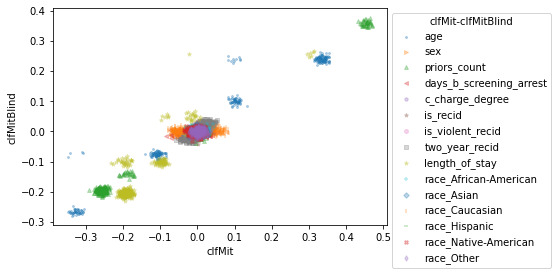

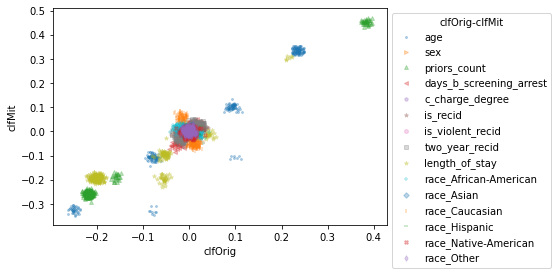

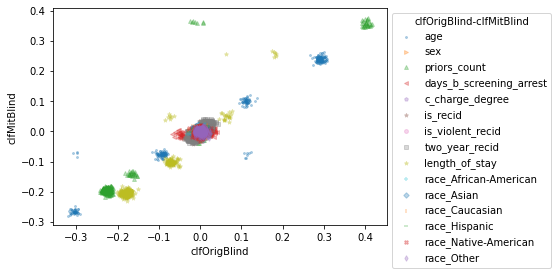

In [30]:
XAIPlots(lime_v,column_names,diffClfs=True)

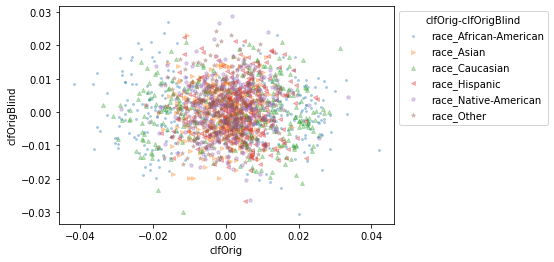

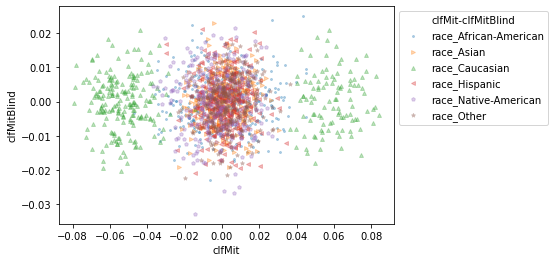

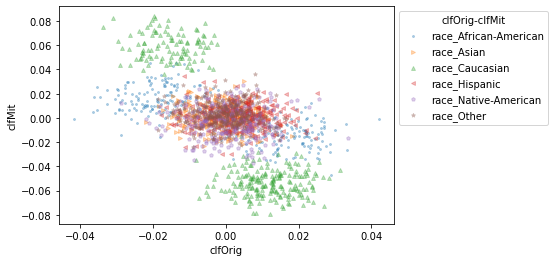

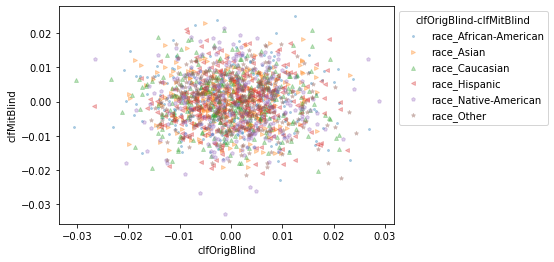

In [31]:
XAIPlots(lime_v,protected,diffClfs=True)

#### XAI Changing Reference Set

##### SHAP Kernel Explainer

In [32]:
shap_v = SHAP(clfs,column_names,X_train,X_train_mod,X_test,protected,changeReferenceSet=True,Tree=False)  
XAISum,XAIMean = deltas(shap_v,column_names)
resSHAP = buildFinalResXAI(XAISum,XAIMean,protected,non_sensitive)

In [33]:
PIK = "PS_MLP_SHAPV_Change.dat"
with open(path_res+"/"+PIK, "wb") as f:
  pickle.dump(shap_v, f)

In [34]:
PIK = "PS_MLP_SHAPV_Change.dat"
with open(path_res+"/"+PIK, "rb") as f:
  shap_v = pickle.load(f)

In [35]:
XAISum,XAIMean = deltas(shap_v,column_names)
XAISum

Empty DataFrame
Columns: []
Index: []

In [36]:
XAIMean

clfOrig-clfOrigBlind  clfMit-clfMitBlind  \
age                                  0.034071            0.048995   
sex                                  0.005446            0.008371   
priors_count                         0.017677            0.061510   
days_b_screening_arrest              0.012234            0.012486   
c_charge_degree                      0.003508            0.007975   
is_recid                             0.005980            0.008351   
is_violent_recid                     0.005345            0.006250   
two_year_recid                       0.003077            0.009011   
length_of_stay                       0.023148            0.032851   
race_African-American                0.020851            0.018245   
race_Asian                           0.000000            0.000178   
race_Caucasian                       0.014045            0.078498   
race_Hispanic                        0.003449            0.002051   
race_Native-American                 0.000056            0.000410   
race_Other                           0.000337            0.001448   

                         clfOrig-clfMit  clfOrigBlind-clfMitBlind  
age                            0.057793                  0.025608  
sex                            0.012285                  0.001833  
priors_count                   0.050613                  0.028817  
days_b_screening_arrest        0.012112                  0.012941  
c_charge_degree                0.007849                  0.004319  
is_recid                       0.009994                  0.003435  
is_violent_recid               0.006175                  0.005759  
two_year_recid                 0.011618                  0.014496  
length_of_stay                 0.029647                  0.030773  
race_African-American          0.039004                  0.000013  
race_Asian                     0.000178                  0.000000  
race_Caucasian                 0.092543                  0.000000  
race_Hispanic                  0.003624                  0.000000  
race_Native-American           0.000354                  0.000000  
race_Other                     0.001138                  0.000000

In [37]:
EValues = computeE(shap_v,column_names)
EValues 

E
clfOrig-clfOrigBlind      0.010
clfMit-clfMitBlind        0.020
clfOrig-clfMit            0.022
clfOrigBlind-clfMitBlind  0.009

In [38]:
resSHAP = buildFinalResXAI(XAISum,XAIMean,protected,non_sensitive)
resSHAP = resSHAP.round(3)
resSHAP.to_csv(path_or_buf=path_res+'PS_MLP_ResSHAP_Change.csv')
resSHAP

clfOrig-clfOrigBlind  clfMit-clfMitBlind  clfOrig-clfMit  \
SA-Mean                  0.006               0.017           0.023   
SA-Sd                    0.008               0.028           0.034   
NSA-Mean                 0.012               0.022           0.022   
NSA-Sd                   0.010               0.020           0.018   

          clfOrigBlind-clfMitBlind  
SA-Mean                      0.000  
SA-Sd                        0.000  
NSA-Mean                     0.014  
NSA-Sd                       0.011

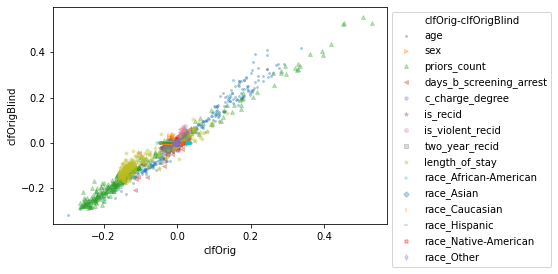

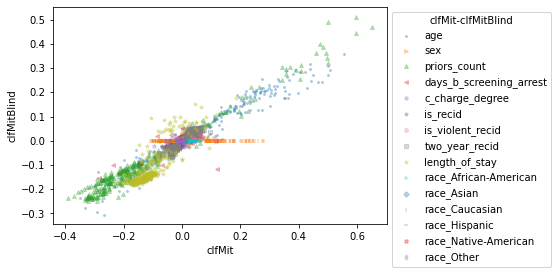

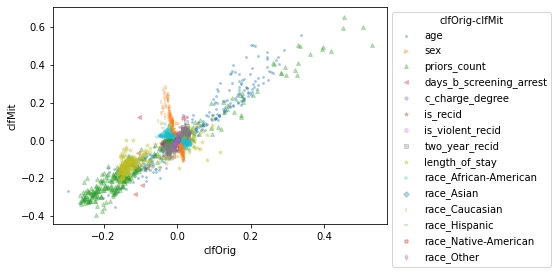

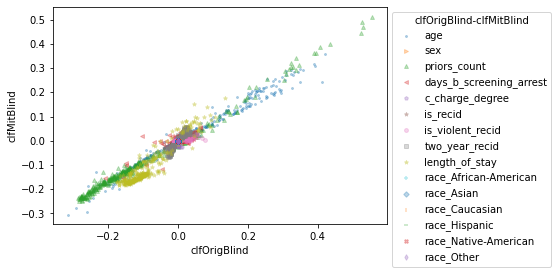

In [39]:
XAIPlots(shap_v,column_names,diffClfs=True)

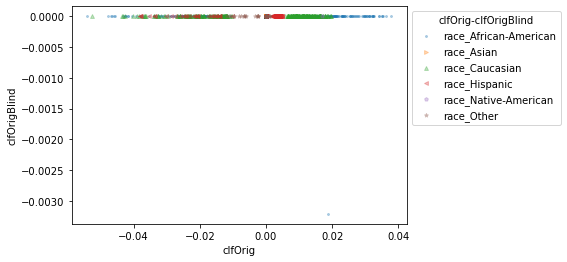

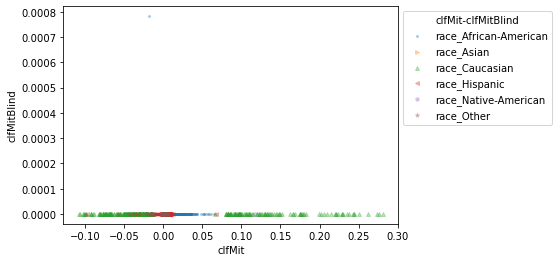

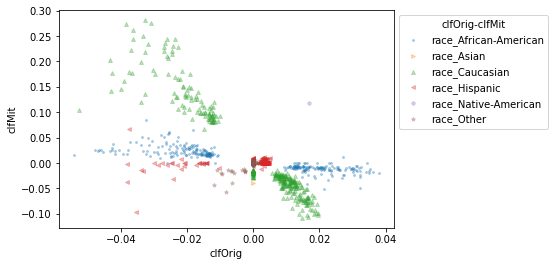

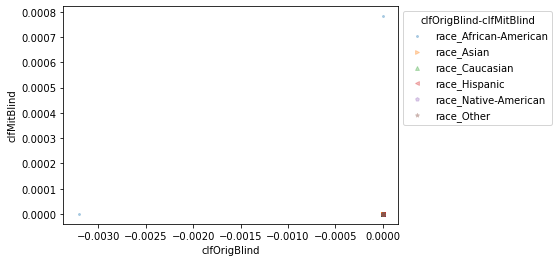

In [40]:
XAIPlots(shap_v,protected,diffClfs=True)

##### LIME

In [41]:
lime_v= LIME(clfs,column_names,class_names,X_train,X_train_mod,X_test,protected,changeReferenceSet=True)
XAISum,XAIMean = deltas(lime_v,column_names)
resLIME = buildFinalResXAI(XAISum,XAIMean,protected,non_sensitive)

In [42]:
PIK = "PS_MLP_LIMEV_Change.dat"
with open(path_res+"/"+PIK, "wb") as f:
  pickle.dump(lime_v, f)

In [43]:
PIK = "PS_MLP_LIMEV_Change.dat"
with open(path_res+"/"+PIK, "rb") as f:
  lime_v = pickle.load(f)

In [44]:
XAISum,XAIMean = deltas(lime_v,column_names)
XAISum

Empty DataFrame
Columns: []
Index: []

In [45]:
XAIMean

clfOrig-clfOrigBlind  clfMit-clfMitBlind  \
age                                  0.047401            0.062333   
sex                                  0.010100            0.011830   
priors_count                         0.019358            0.069759   
days_b_screening_arrest              0.011127            0.017157   
c_charge_degree                      0.009839            0.011178   
is_recid                             0.009897            0.011376   
is_violent_recid                     0.008583            0.012072   
two_year_recid                       0.008846            0.010338   
length_of_stay                       0.020682            0.037043   
race_African-American                0.018806            0.017954   
race_Asian                           0.007886            0.009100   
race_Caucasian                       0.015004            0.062728   
race_Hispanic                        0.009112            0.010822   
race_Native-American                 0.009240            0.011601   
race_Other                           0.008066            0.010027   

                         clfOrig-clfMit  clfOrigBlind-clfMitBlind  
age                            0.080703                  0.035319  
sex                            0.013747                  0.008969  
priors_count                   0.069387                  0.033838  
days_b_screening_arrest        0.013120                  0.016117  
c_charge_degree                0.010577                  0.010205  
is_recid                       0.012123                  0.009294  
is_violent_recid               0.011052                  0.009912  
two_year_recid                 0.011238                  0.010500  
length_of_stay                 0.040371                  0.028012  
race_African-American          0.033644                  0.009659  
race_Asian                     0.009625                  0.008123  
race_Caucasian                 0.076049                  0.009830  
race_Hispanic                  0.010252                  0.009061  
race_Native-American           0.012793                  0.009552  
race_Other                     0.009910                  0.008930

In [46]:
EValues = computeE(lime_v,column_names)
EValues 

E
clfOrig-clfOrigBlind      0.014
clfMit-clfMitBlind        0.024
clfOrig-clfMit            0.028
clfOrigBlind-clfMitBlind  0.014

In [47]:
resLIME = buildFinalResXAI(XAISum,XAIMean,protected,non_sensitive)
resLIME = resLIME.round(3)
resLIME.to_csv(path_or_buf=path_res+'PS_MLP_ResLIME_Change.csv')
resLIME

clfOrig-clfOrigBlind  clfMit-clfMitBlind  clfOrig-clfMit  \
SA-Mean                  0.011               0.020           0.025   
SA-Sd                    0.004               0.019           0.024   
NSA-Mean                 0.016               0.027           0.029   
NSA-Sd                   0.012               0.022           0.026   

          clfOrigBlind-clfMitBlind  
SA-Mean                      0.009  
SA-Sd                        0.001  
NSA-Mean                     0.018  
NSA-Sd                       0.011

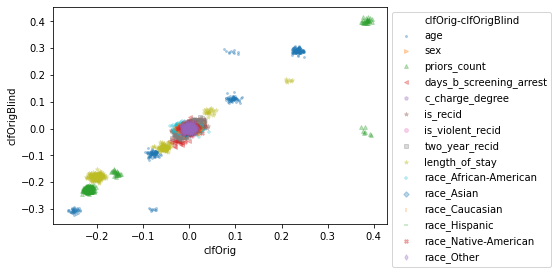

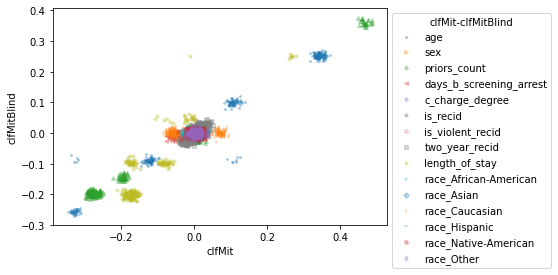

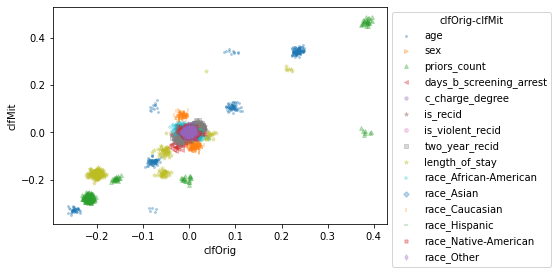

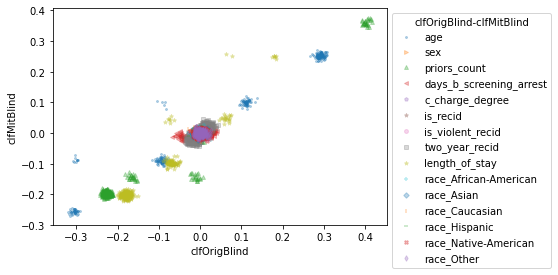

In [48]:
XAIPlots(lime_v,column_names,diffClfs=True)

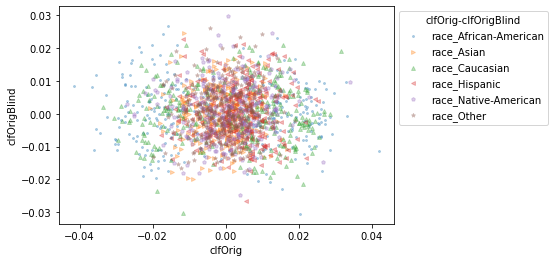

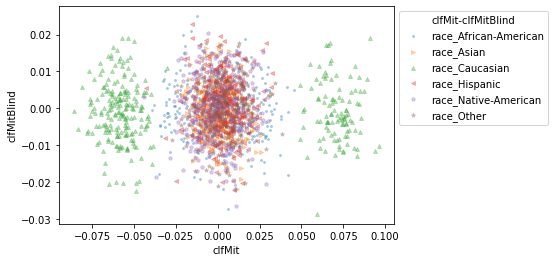

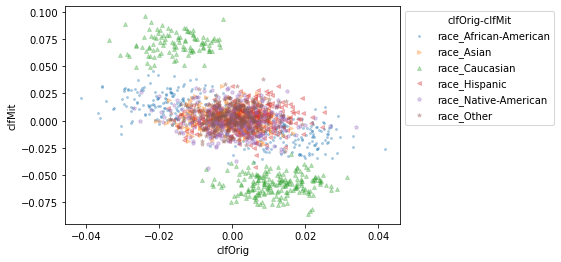

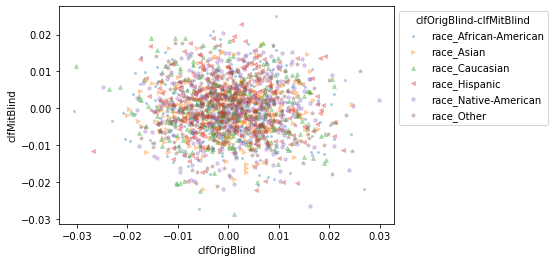

In [49]:
XAIPlots(lime_v,protected,diffClfs=True)

#### Comparison

##### SHAP Kernel Explainer

In [50]:
PIK = "PS_MLP_SHAPV_Fix.dat"
with open(path_res+"/"+PIK, "rb") as f:
  shap_v_fix = pickle.load(f)

In [51]:
PIK = "PS_MLP_SHAPV_Change.dat"
with open(path_res+"/"+PIK, "rb") as f:
  shap_v_change = pickle.load(f)

In [52]:
XAISum,XAIMean = deltas(shap_v_fix,column_names,False,shap_v_change)
XAISum

Empty DataFrame
Columns: []
Index: []

In [53]:
XAIMean

clfOrig-clfOrig  clfMit-clfMit  \
age                             0.006250       0.015667   
sex                             0.000316       0.001482   
priors_count                    0.003001       0.006575   
days_b_screening_arrest         0.000992       0.002669   
c_charge_degree                 0.000617       0.001106   
is_recid                        0.000686       0.001217   
is_violent_recid                0.000325       0.001332   
two_year_recid                  0.000581       0.001113   
length_of_stay                  0.003604       0.006671   
race_African-American           0.000916       0.001795   
race_Asian                      0.000000       0.000092   
race_Caucasian                  0.000621       0.005645   
race_Hispanic                   0.000344       0.000670   
race_Native-American            0.000005       0.000055   
race_Other                      0.000035       0.000354   

                         clfOrigBlind-clfOrigBlind  clfMitBlind-clfMitBlind  
age                                       0.009383                 0.011476  
sex                                       0.000396                 0.000138  
priors_count                              0.007441                 0.004098  
days_b_screening_arrest                   0.001289                 0.000942  
c_charge_degree                           0.000546                 0.000725  
is_recid                                  0.000894                 0.000845  
is_violent_recid                          0.000690                 0.000373  
two_year_recid                            0.000968                 0.001506  
length_of_stay                            0.001704                 0.006896  
race_African-American                     0.000011                 0.000003  
race_Asian                                0.000000                 0.000000  
race_Caucasian                            0.000000                 0.000000  
race_Hispanic                             0.000004                 0.000000  
race_Native-American                      0.000013                 0.000005  
race_Other                                0.000000                 0.000000

In [54]:
resSHAP = buildFinalResXAI(XAISum,XAIMean,protected,non_sensitive)
resSHAP = resSHAP.round(3)
resSHAP

clfOrig-clfOrig  clfMit-clfMit  clfOrigBlind-clfOrigBlind  \
SA-Mean             0.000          0.001                      0.000   
SA-Sd               0.000          0.002                      0.000   
NSA-Mean            0.002          0.004                      0.003   
NSA-Sd              0.002          0.005                      0.003   

          clfMitBlind-clfMitBlind  
SA-Mean                     0.000  
SA-Sd                       0.000  
NSA-Mean                    0.003  
NSA-Sd                      0.004

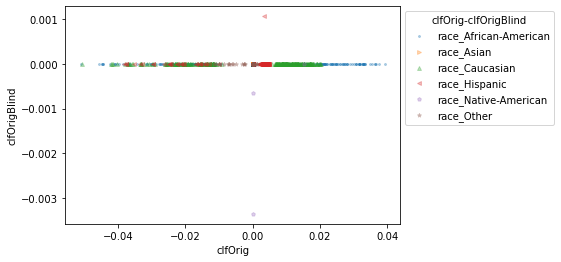

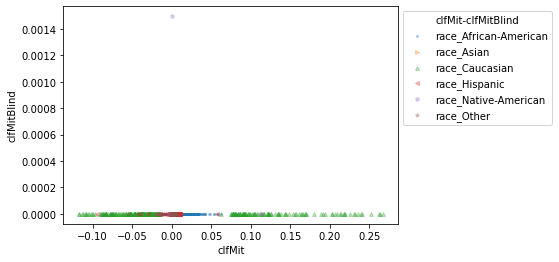

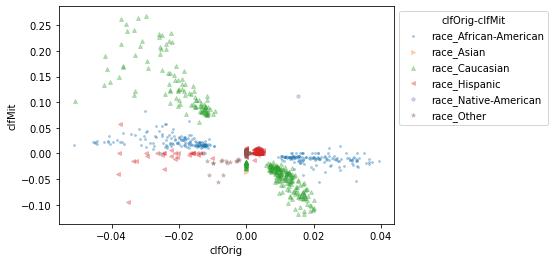

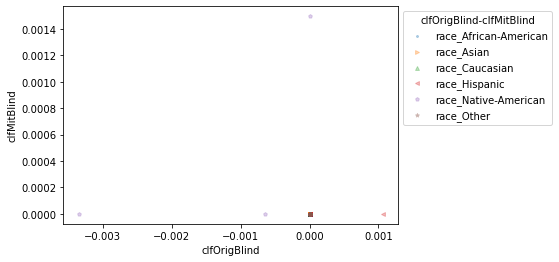

In [55]:
XAIPlots(shap_v_fix,protected,True,shap_v_change)

##### LIME

In [56]:
PIK = "PS_MLP_LIMEV_Fix.dat"
with open(path_res+"/"+PIK, "rb") as f:
  lime_v_fix = pickle.load(f)

In [57]:
PIK = "PS_MLP_LIMEV_Change.dat"
with open(path_res+"/"+PIK, "rb") as f:
  lime_v_change = pickle.load(f)

In [58]:
XAISum,XAIMean = deltas(lime_v_fix,column_names,False,lime_v_change)
XAISum

Empty DataFrame
Columns: []
Index: []

In [59]:
XAIMean

clfOrig-clfOrig  clfMit-clfMit  \
age                             0.000103       0.036733   
sex                             0.000088       0.010185   
priors_count                    0.000093       0.039844   
days_b_screening_arrest         0.000876       0.012740   
c_charge_degree                 0.000112       0.012973   
is_recid                        0.000103       0.012559   
is_violent_recid                0.000108       0.012067   
two_year_recid                  0.000106       0.012213   
length_of_stay                  0.000108       0.021532   
race_African-American           0.000110       0.013259   
race_Asian                      0.001006       0.010880   
race_Caucasian                  0.000125       0.013241   
race_Hispanic                   0.000096       0.011182   
race_Native-American            0.002376       0.014058   
race_Other                      0.001577       0.012140   

                         clfOrigBlind-clfOrigBlind  clfMitBlind-clfMitBlind  
age                                       0.000103                 0.021902  
sex                                       0.000090                 0.008330  
priors_count                              0.000091                 0.023769  
days_b_screening_arrest                   0.000099                 0.008918  
c_charge_degree                           0.000113                 0.009133  
is_recid                                  0.000108                 0.009115  
is_violent_recid                          0.000103                 0.009274  
two_year_recid                            0.000100                 0.008269  
length_of_stay                            0.000114                 0.009574  
race_African-American                     0.000104                 0.008152  
race_Asian                                0.001201                 0.007952  
race_Caucasian                            0.000099                 0.008830  
race_Hispanic                             0.000101                 0.008813  
race_Native-American                      0.002853                 0.009888  
race_Other                                0.001866                 0.008504

In [60]:
resLIME = buildFinalResXAI(XAISum,XAIMean,protected,non_sensitive)
resLIME = resLIME.round(3)
resLIME

clfOrig-clfOrig  clfMit-clfMit  clfOrigBlind-clfOrigBlind  \
SA-Mean             0.001          0.012                      0.001   
SA-Sd               0.001          0.001                      0.001   
NSA-Mean            0.000          0.019                      0.000   
NSA-Sd              0.000          0.011                      0.000   

          clfMitBlind-clfMitBlind  
SA-Mean                     0.009  
SA-Sd                       0.001  
NSA-Mean                    0.012  
NSA-Sd                      0.006

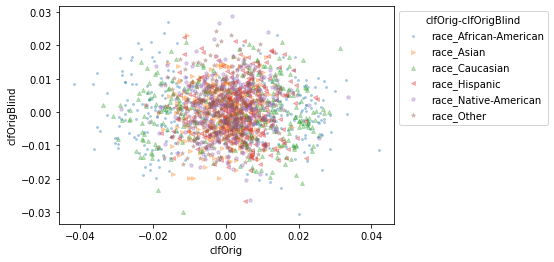

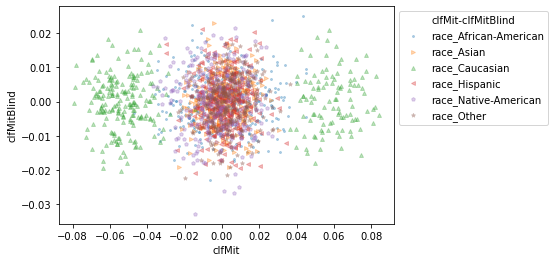

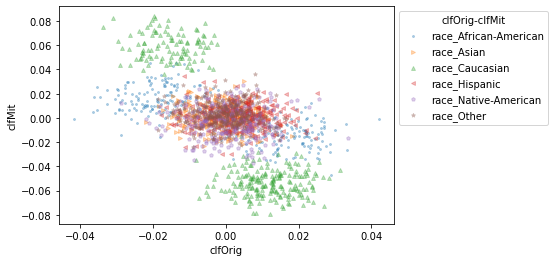

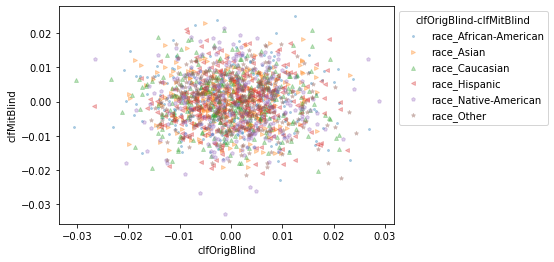

In [61]:
XAIPlots(lime_v_fix,protected,True,lime_v_change)

### RF

In [62]:

clf = RandomForestClassifier()
param_grid = {'n_estimators': [200, 500], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth' : [4,5,6,7,8], 'criterion' : ['gini', 'entropy'], 'bootstrap' : [True, False]}

In [63]:

clfOrig,clfOrigBlind,clfMit,clfMitBlind,res = Classifiers(clf,param_grid,target,column_names,X_train,X_train_mod,X_train_blind,X_train_mod_blind,y_train,y_train_mod,X_test,X_test_blind,y_test,protected,adClass,disClass,adAttr,disAttr)
res.to_csv(path_or_buf=path_res+'PS_RF_Performances.csv')
res

Original Train Dimension = 4320
Mitigated Train Dimension = 4320
Test Dimension = 300
---> CLF Original: 
Favoured attribute value: [ race_Caucasian ] Freq.: [ 105 ] Labeled as + class: [ 99 ]
Unfavoured attribute value: [ race_African-American ] Freq.: [ 149 ] Labeled as + class: [ 106 ]
---> CLF Mitigated: 
Favoured attribute value: [ race_Caucasian ] Freq.: [ 105 ] Labeled as + class: [ 77 ]
Unfavoured attribute value: [ race_African-American ] Freq.: [ 149 ] Labeled as + class: [ 120 ]
---> CLF Original Blind: 
Favoured attribute value: [ race_Caucasian ] Freq.: [ 105 ] Labeled as + class: [ 95 ]
Unfavoured attribute value: [ race_African-American ] Freq.: [ 149 ] Labeled as + class: [ 111 ]
---> CLF Mitigated Blind: 
Favoured attribute value: [ race_Caucasian ] Freq.: [ 105 ] Labeled as + class: [ 92 ]
Unfavoured attribute value: [ race_African-American ] Freq.: [ 149 ] Labeled as + class: [ 109 ]


CLF Original  CLF Original Blind  CLF Mitigated  \
F1 Score            0.536232            0.524823       0.493151   
Discrimination      0.231448            0.159795      -0.072036   

                CLF Mitigated Blind           Best Score  Delta O-OB  \
F1 Score                   0.575342  CLF Mitigated Blind    0.011409   
Discrimination             0.144647        CLF Mitigated    0.071652   

                Delta M-MB  Delta O-M  Delta OB-MB  
F1 Score          0.082192   0.043081     0.050520  
Discrimination    0.216683   0.303484     0.015149

In [118]:

PIK = "PS_Clfs_RF.dat"
with open(path_res+"/"+PIK, "wb") as f:
  pickle.dump([clfOrig,clfOrigBlind,clfMit,clfMitBlind], f)

In [119]:
PIK = "PS_Clfs_RF.dat"
with open(path_res+"/"+PIK, "rb") as f:
  clfOrig,clfOrigBlind,clfMit,clfMitBlind = pickle.load(f)
clfs={'clfOrig':clfOrig,'clfOrigBlind':clfOrigBlind,'clfMit':clfMit,'clfMitBlind':clfMitBlind}

In [120]:
res = pd.read_csv(path_res+'PS_RF_Performances.csv',index_col=0)
res = res.round(3)
res.to_csv(path_res+'PS_RF_Performances.csv')
res

CLF Original  CLF Original Blind  CLF Mitigated  \
F1 Score               0.661               0.683          0.512   
Discrimination         0.213               0.123         -0.074   

                CLF Mitigated Blind          Best Score  Delta O-OB  \
F1 Score                      0.667  CLF Original Blind       0.022   
Discrimination                0.150       CLF Mitigated       0.089   

                Delta M-MB  Delta O-M  Delta OB-MB  
F1 Score             0.154      0.149        0.016  
Discrimination       0.224      0.286        0.027

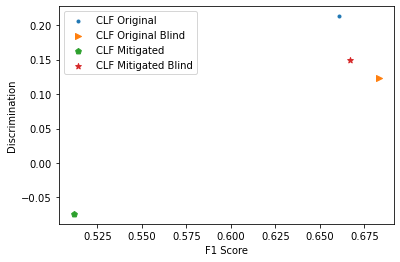

In [121]:
plotDisc(res)

In [122]:
FATInput=DataDescription(X_test,y_test,class_names,column_names,protected,protected_feature)

The grouping based on the *races* feature has the following distribution:
    * "('race_African-American',)" grouping has 152 instances.
    * "('race_Asian',)" grouping has 1 instances.
    * "('race_Caucasian',)" grouping has 105 instances.
    * "('race_Hispanic',)" grouping has 32 instances.
    * "('race_Other',)" grouping has 10 instances.

The class distribution per sub-population:
    * For the "('race_African-American',)" grouping the classes are distributed as follows:
        - The class *Medium-Low* has 98 data points.
        - The class *High* has 54 data points.
    * For the "('race_Asian',)" grouping the classes are distributed as follows:
        - The class *Medium-Low* has 1 data points.
    * For the "('race_Caucasian',)" grouping the classes are distributed as follows:
        - The class *Medium-Low* has 93 data points.
        - The class *High* has 12 data points.
    * For the "('race_Hispanic',)" grouping the classes are distributed as follows:
        - The 

In [123]:
resDisparateImp=disparateImpactMetrics(clfs,FATInput,X_test,X_test_blind,y_test,protected_feature)
resDisparateImp

The *Equal Accuracy* group-based fairness metric for *races* feature split are:
    *  NOT  satisfied for "('race_African-American',)" and "('race_Asian',)" sub-populations.
    *  NOT  satisfied for "('race_African-American',)" and "('race_Other',)" sub-populations.
The *Equal Opportunity* group-based fairness metric for *races* feature split are:
The *Demographic Parity* group-based fairness metric for *races* feature split are:


Some of the given labels are not present in either of the input arrays: {1}.
Some of the given labels are not present in either of the input arrays: {1}.
Some of the given labels are not present in either of the input arrays: {1}.


The *Equal Accuracy* group-based fairness metric for *races* feature split are:
The *Equal Opportunity* group-based fairness metric for *races* feature split are:
The *Demographic Parity* group-based fairness metric for *races* feature split are:
The *Equal Accuracy* group-based fairness metric for *races* feature split are:
    *  NOT  satisfied for "('race_African-American',)" and "('race_Asian',)" sub-populations.
    *  NOT  satisfied for "('race_African-American',)" and "('race_Hispanic',)" sub-populations.
    *  NOT  satisfied for "('race_African-American',)" and "('race_Other',)" sub-populations.
The *Equal Opportunity* group-based fairness metric for *races* feature split are:
The *Demographic Parity* group-based fairness metric for *races* feature split are:
    *  NOT  satisfied for "('race_African-American',)" and "('race_Asian',)" sub-populations.
    *  NOT  satisfied for "('race_African-American',)" and "('race_Caucasian',)" sub-populations.
    *  NOT  satisfied for "('

Some of the given labels are not present in either of the input arrays: {1}.


{'Equal Accuracy': {'Delta O-OB': ["'race_African-American' 'race_Asian' ",
   "'race_African-American' 'race_Other' "],
  'Delta M-MB': ["'race_African-American' 'race_Hispanic' "],
  'Delta O-M': ["'race_African-American' 'race_Hispanic' "],
  'Delta OB-MB': ["'race_African-American' 'race_Asian' ",
   "'race_African-American' 'race_Other' "]},
 'Equal Opportunity': {'Delta O-OB': [],
  'Delta M-MB': [],
  'Delta O-M': [],
  'Delta OB-MB': []},
 'Demographic Parity': {'Delta O-OB': [],
  'Delta M-MB': ["'race_African-American' 'race_Hispanic' ",
   "'race_African-American' 'race_Asian' ",
   "'race_African-American' 'race_Other' ",
   "'race_African-American' 'race_Caucasian' "],
  'Delta O-M': ["'race_African-American' 'race_Other' ",
   "'race_African-American' 'race_Asian' ",
   "'race_African-American' 'race_Caucasian' ",
   "'race_African-American' 'race_Hispanic' "],
  'Delta OB-MB': []}}

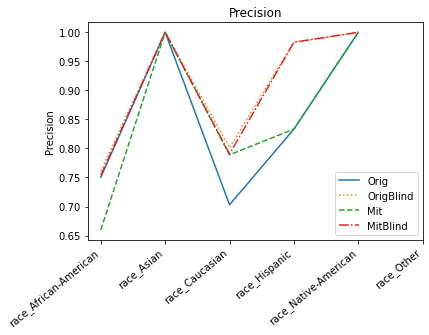

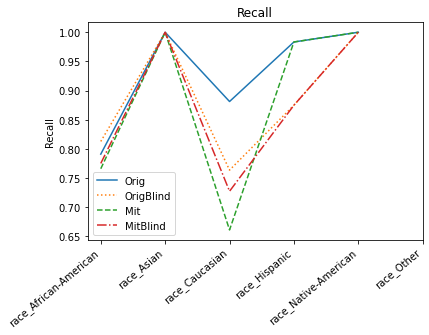

In [124]:
standardMetricsPerGroup(clfs,column_names,target,X_test,y_test,protected_feature,protected)

#### XAI Fixed Reference Set

##### SHAP Kernel Explainer

In [65]:
shap_v = SHAP(clfs,column_names,X_train,X_train_mod,X_test,protected,changeReferenceSet=False,Tree=False)  
XAISum,XAIMean = deltas(shap_v,column_names)
resSHAP = buildFinalResXAI(XAISum,XAIMean,protected,non_sensitive)

In [66]:
PIK = "PS_RF_SHAPV_Fix.dat"
with open(path_res+"/"+PIK, "wb") as f:
  pickle.dump(shap_v, f)

In [67]:
PIK = "PS_RF_SHAPV_Fix.dat"
with open(path_res+"/"+PIK, "rb") as f:
  shap_v = pickle.load(f)

In [68]:
XAISum,XAIMean = deltas(shap_v,column_names)
XAISum

Empty DataFrame
Columns: []
Index: []

In [69]:
XAIMean

clfOrig-clfOrigBlind  clfMit-clfMitBlind  \
age                                  0.028553            0.027126   
sex                                  0.000797            0.001639   
priors_count                         0.027546            0.029875   
days_b_screening_arrest              0.005381            0.005508   
c_charge_degree                      0.002183            0.004139   
is_recid                             0.004937            0.012216   
is_violent_recid                     0.001389            0.001688   
two_year_recid                       0.007745            0.009941   
length_of_stay                       0.011397            0.016239   
race_African-American                0.045964            0.010142   
race_Asian                           0.000054            0.000047   
race_Caucasian                       0.012240            0.034562   
race_Hispanic                        0.002697            0.002981   
race_Native-American                 0.000218            0.000254   
race_Other                           0.002027            0.001862   

                         clfOrig-clfMit  clfOrigBlind-clfMitBlind  
age                            0.020748                  0.016371  
sex                            0.000901                  0.001667  
priors_count                   0.012918                  0.019309  
days_b_screening_arrest        0.004741                  0.005698  
c_charge_degree                0.006044                  0.004745  
is_recid                       0.008955                  0.007671  
is_violent_recid               0.001071                  0.001374  
two_year_recid                 0.013708                  0.017678  
length_of_stay                 0.010497                  0.014474  
race_African-American          0.056106                  0.000000  
race_Asian                     0.000006                  0.000000  
race_Caucasian                 0.046748                  0.000000  
race_Hispanic                  0.000837                  0.000000  
race_Native-American           0.000038                  0.000004  
race_Other                     0.000204                  0.000004

In [70]:
EValues = computeE(shap_v,column_names)
EValues 

E
clfOrig-clfOrigBlind      0.010
clfMit-clfMitBlind        0.011
clfOrig-clfMit            0.012
clfOrigBlind-clfMitBlind  0.006

In [71]:
resSHAP = buildFinalResXAI(XAISum,XAIMean,protected,non_sensitive)
resSHAP = resSHAP.round(3)
resSHAP.to_csv(path_or_buf=path_res+'PS_RF_ResSHAP_Fix.csv')
resSHAP

clfOrig-clfOrigBlind  clfMit-clfMitBlind  clfOrig-clfMit  \
SA-Mean                  0.011               0.008           0.017   
SA-Sd                    0.016               0.012           0.024   
NSA-Mean                 0.010               0.012           0.009   
NSA-Sd                   0.010               0.010           0.006   

          clfOrigBlind-clfMitBlind  
SA-Mean                      0.000  
SA-Sd                        0.000  
NSA-Mean                     0.010  
NSA-Sd                       0.007

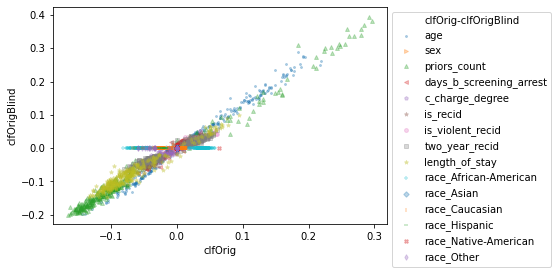

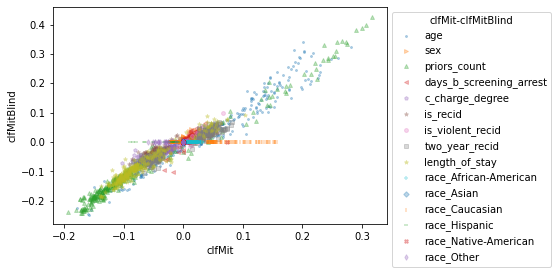

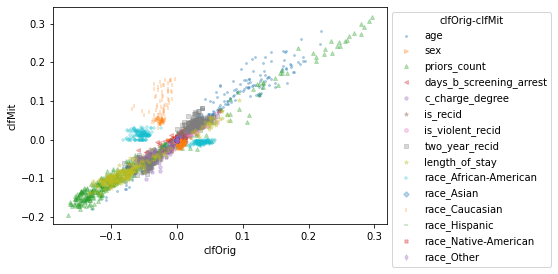

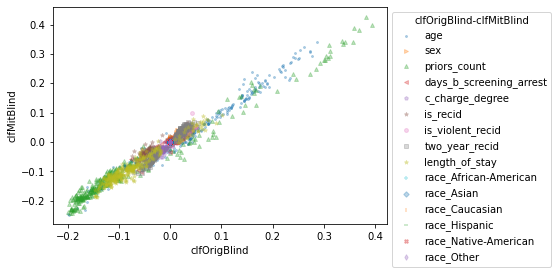

In [72]:
XAIPlots(shap_v,column_names,diffClfs=True)

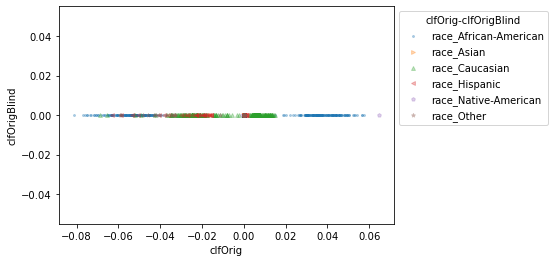

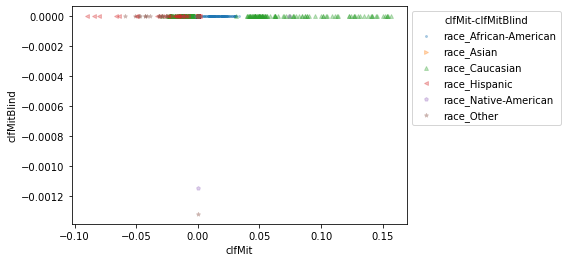

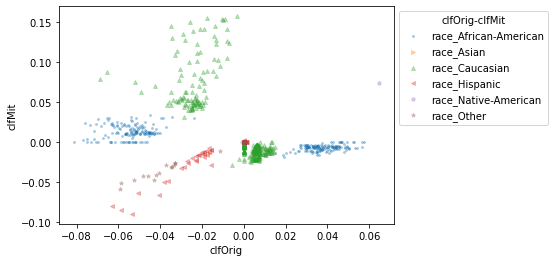

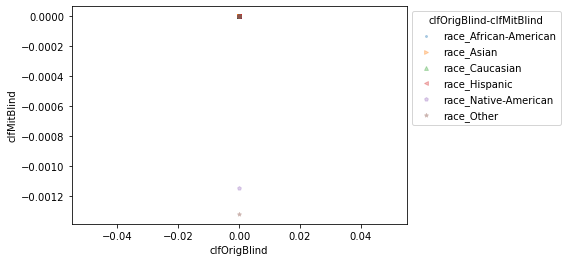

In [73]:
XAIPlots(shap_v,protected,diffClfs=True)

##### SHAP Explainer 4 Trees

In [ ]:
shap_v = SHAP(clfs,column_names,X_train,X_train_mod,X_test,protected,changeReferenceSet=False,Tree=True)  
XAISum,XAIMean = deltas(shap_v,column_names)
resSHAP = buildFinalResXAI(XAISum,XAIMean,protected,non_sensitive)

In [ ]:
PIK = "PS_RF_SHAPV_Fix_Tree.dat"
with open(path_res+"/"+PIK, "wb") as f:
  pickle.dump(shap_v, f)

In [55]:
PIK = "PS_RF_SHAPV_Fix_Tree.dat"
with open(path_res+"/"+PIK, "rb") as f:
  shap_v = pickle.load(f)

In [ ]:
XAISum,XAIMean = deltas(shap_v,column_names)
XAISum

In [ ]:
XAIMean

In [ ]:
EValues = computeE(shap_v,column_names)
EValues 

In [ ]:
resSHAP = pd.read_csv(path_res+'PS_RF_ResSHAP_Fix_Tree.csv',index_col=0)
resSHAP = resSHAP.round(3)
resSHAP.to_csv(path_or_buf=path_res+'PS_RF_ResSHAP_Fix_Tree.csv')
resSHAP

In [ ]:
XAIPlots(shap_v,column_names,diffClfs=True)

In [ ]:
XAIPlots(shap_v,protected,diffClfs=True)

##### LIME

In [74]:
lime_v= LIME(clfs,column_names,class_names,X_train,X_train_mod,X_test,protected,changeReferenceSet=False)
XAISum,XAIMean = deltas(lime_v,column_names)
resLIME = buildFinalResXAI(XAISum,XAIMean,protected,non_sensitive)

In [75]:
PIK = "PS_RF_LIMEV_Fix.dat"
with open(path_res+"/"+PIK, "wb") as f:
  pickle.dump(lime_v, f)

In [76]:
PIK = "PS_RF_LIMEV_Fix.dat"
with open(path_res+"/"+PIK, "rb") as f:
  lime_v = pickle.load(f)

In [77]:
XAISum,XAIMean = deltas(lime_v,column_names)
XAISum

Empty DataFrame
Columns: []
Index: []

In [78]:
XAIMean

clfOrig-clfOrigBlind  clfMit-clfMitBlind  \
age                                  0.045537            0.027685   
sex                                  0.006581            0.006267   
priors_count                         0.048148            0.031492   
days_b_screening_arrest              0.007004            0.008553   
c_charge_degree                      0.006328            0.007407   
is_recid                             0.008454            0.016026   
is_violent_recid                     0.007185            0.007063   
two_year_recid                       0.009939            0.007735   
length_of_stay                       0.007077            0.017609   
race_African-American                0.063051            0.015105   
race_Asian                           0.005707            0.006424   
race_Caucasian                       0.021905            0.044750   
race_Hispanic                        0.005949            0.006518   
race_Native-American                 0.006051            0.007876   
race_Other                           0.005675            0.006117   

                         clfOrig-clfMit  clfOrigBlind-clfMitBlind  
age                            0.027220                  0.015543  
sex                            0.005345                  0.006524  
priors_count                   0.010540                  0.021291  
days_b_screening_arrest        0.006606                  0.007649  
c_charge_degree                0.008592                  0.008476  
is_recid                       0.011133                  0.013478  
is_violent_recid               0.005863                  0.007433  
two_year_recid                 0.011146                  0.015576  
length_of_stay                 0.015855                  0.012539  
race_African-American          0.077955                  0.007893  
race_Asian                     0.005786                  0.006330  
race_Caucasian                 0.066701                  0.007638  
race_Hispanic                  0.005693                  0.006921  
race_Native-American           0.006562                  0.008243  
race_Other                     0.005267                  0.007224

In [79]:
EValues = computeE(lime_v,column_names)
EValues 

E
clfOrig-clfOrigBlind      0.017
clfMit-clfMitBlind        0.014
clfOrig-clfMit            0.018
clfOrigBlind-clfMitBlind  0.010

In [80]:
resLIME = buildFinalResXAI(XAISum,XAIMean,protected,non_sensitive)
resLIME = resLIME.round(3)
resLIME.to_csv(path_or_buf=path_res+'PS_RF_ResLIME_Fix.csv')
resLIME

clfOrig-clfOrigBlind  clfMit-clfMitBlind  clfOrig-clfMit  \
SA-Mean                  0.018               0.014           0.028   
SA-Sd                    0.021               0.014           0.032   
NSA-Mean                 0.016               0.014           0.011   
NSA-Sd                   0.016               0.009           0.006   

          clfOrigBlind-clfMitBlind  
SA-Mean                      0.007  
SA-Sd                        0.001  
NSA-Mean                     0.012  
NSA-Sd                       0.005

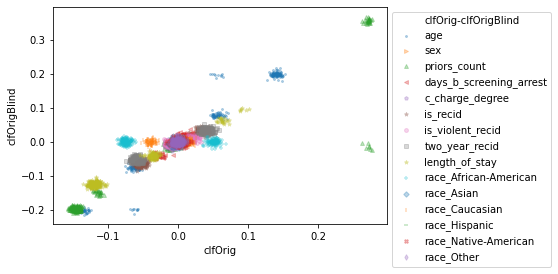

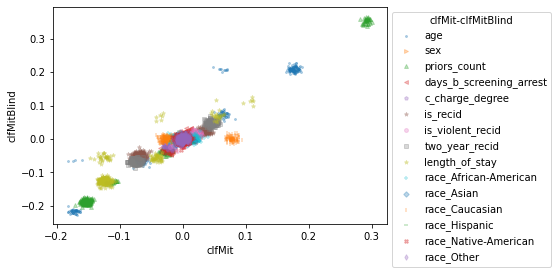

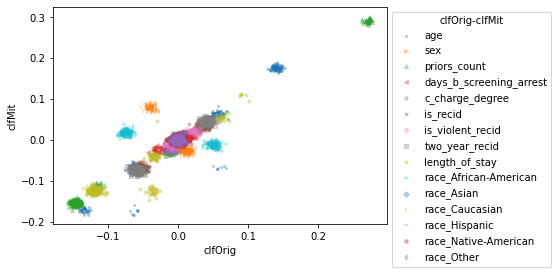

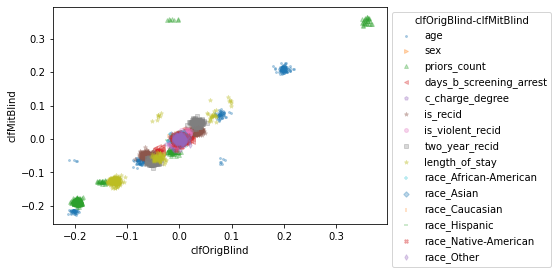

In [81]:
XAIPlots(lime_v,column_names,diffClfs=True)

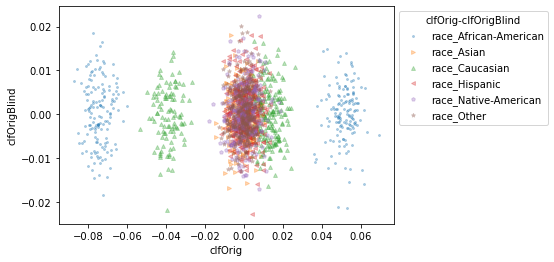

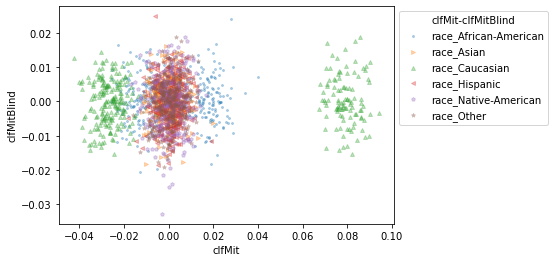

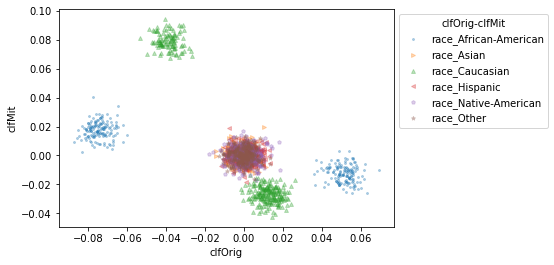

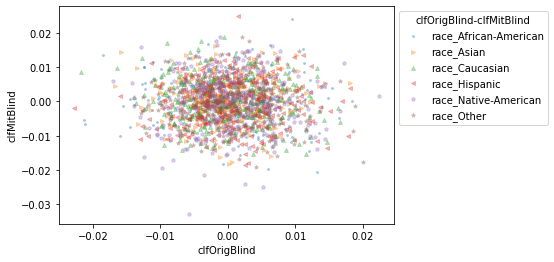

In [82]:
XAIPlots(lime_v,protected,diffClfs=True)

#### XAI Changing Reference Set

##### SHAP Kernel Explainer

In [83]:
shap_v = SHAP(clfs,column_names,X_train,X_train_mod,X_test,protected,changeReferenceSet=True,Tree=False)  
XAISum,XAIMean = deltas(shap_v,column_names)
resSHAP = buildFinalResXAI(XAISum,XAIMean,protected,non_sensitive)

In [84]:
PIK = "PS_RF_SHAPV_Change.dat"
with open(path_res+"/"+PIK, "wb") as f:
  pickle.dump(shap_v, f)

In [85]:
PIK = "PS_RF_SHAPV_Change.dat"
with open(path_res+"/"+PIK, "rb") as f:
  shap_v = pickle.load(f)

In [86]:
XAISum,XAIMean = deltas(shap_v,column_names)
XAISum

Empty DataFrame
Columns: []
Index: []

In [87]:
XAIMean

clfOrig-clfOrigBlind  clfMit-clfMitBlind  \
age                                  0.030344            0.026194   
sex                                  0.000848            0.001956   
priors_count                         0.032823            0.022234   
days_b_screening_arrest              0.004646            0.006101   
c_charge_degree                      0.002156            0.004666   
is_recid                             0.004921            0.013905   
is_violent_recid                     0.001758            0.002053   
two_year_recid                       0.008308            0.009864   
length_of_stay                       0.010053            0.012180   
race_African-American                0.044883            0.010541   
race_Asian                           0.000057            0.000048   
race_Caucasian                       0.012134            0.036567   
race_Hispanic                        0.002691            0.003202   
race_Native-American                 0.000207            0.000251   
race_Other                           0.002000            0.001891   

                         clfOrig-clfMit  clfOrigBlind-clfMitBlind  
age                            0.019261                  0.018048  
sex                            0.000944                  0.002053  
priors_count                   0.015238                  0.016272  
days_b_screening_arrest        0.004813                  0.005220  
c_charge_degree                0.006055                  0.003844  
is_recid                       0.009914                  0.008397  
is_violent_recid               0.001406                  0.001737  
two_year_recid                 0.013621                  0.017644  
length_of_stay                 0.009832                  0.010768  
race_African-American          0.055398                  0.000000  
race_Asian                     0.000016                  0.000007  
race_Caucasian                 0.048614                  0.000004  
race_Hispanic                  0.000883                  0.000000  
race_Native-American           0.000044                  0.000000  
race_Other                     0.000193                  0.000000

In [88]:
EValues = computeE(shap_v,column_names)
EValues 

E
clfOrig-clfOrigBlind      0.011
clfMit-clfMitBlind        0.010
clfOrig-clfMit            0.012
clfOrigBlind-clfMitBlind  0.006

In [89]:
resSHAP = buildFinalResXAI(XAISum,XAIMean,protected,non_sensitive)
resSHAP = resSHAP.round(3)
resSHAP.to_csv(path_or_buf=path_res+'PS_RF_ResSHAP_Change.csv')
resSHAP

clfOrig-clfOrigBlind  clfMit-clfMitBlind  clfOrig-clfMit  \
SA-Mean                  0.010               0.009           0.018   
SA-Sd                    0.016               0.013           0.024   
NSA-Mean                 0.011               0.011           0.009   
NSA-Sd                   0.012               0.008           0.006   

          clfOrigBlind-clfMitBlind  
SA-Mean                      0.000  
SA-Sd                        0.000  
NSA-Mean                     0.009  
NSA-Sd                       0.006

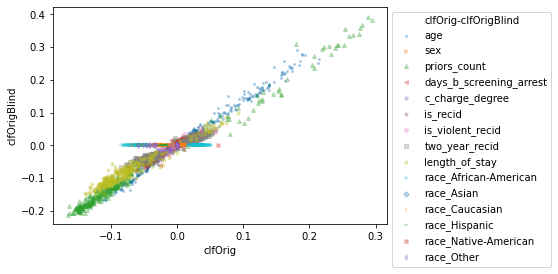

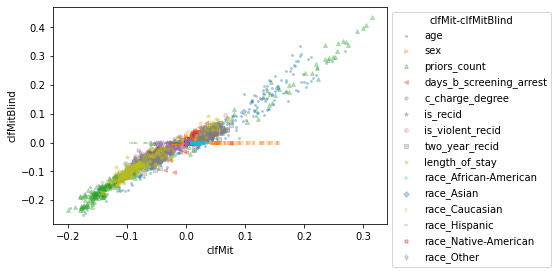

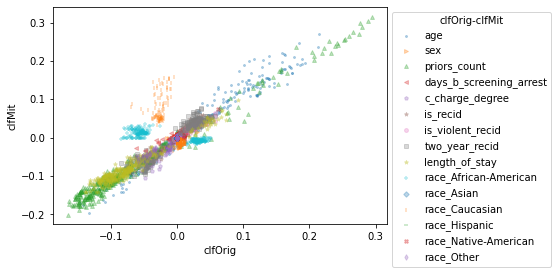

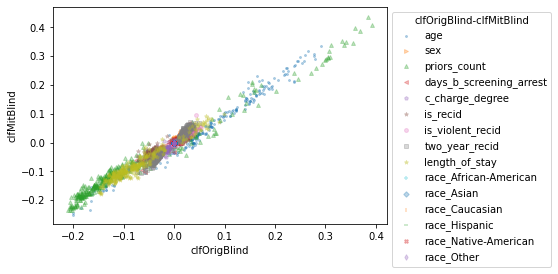

In [90]:
XAIPlots(shap_v,column_names,diffClfs=True)

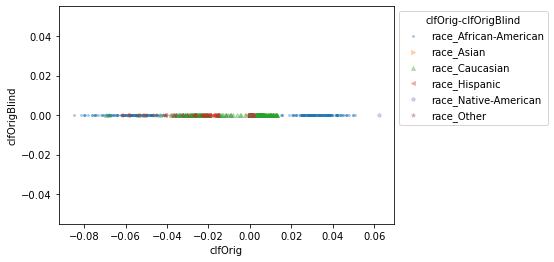

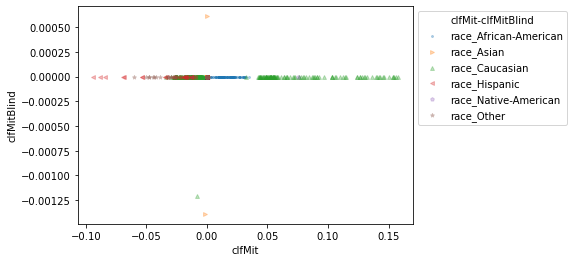

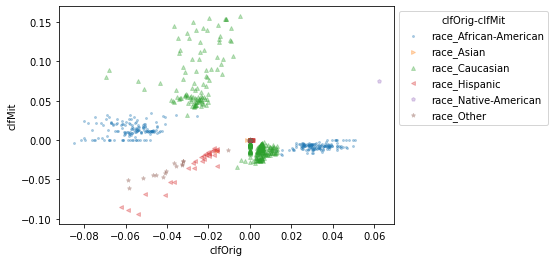

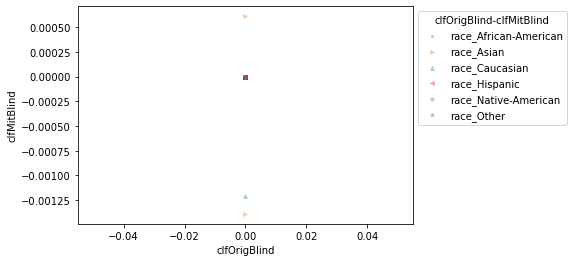

In [91]:
XAIPlots(shap_v,protected,diffClfs=True)

##### SHAP Explainer 4 Trees

In [ ]:
shap_v = SHAP(clfs,column_names,X_train,X_train_mod,X_test,protected,changeReferenceSet=True,Tree=True)  
XAISum,XAIMean = deltas(shap_v,column_names)
resSHAP = buildFinalResXAI(XAISum,XAIMean,protected,non_sensitive)

In [ ]:
PIK = "PS_RF_SHAPV_Change_Tree.dat"
with open(path_res+"/"+PIK, "wb") as f:
  pickle.dump(shap_v, f)

In [ ]:
PIK = "PS_RF_SHAPV_Change_Tree.dat"
with open(path_res+"/"+PIK, "rb") as f:
  shap_v = pickle.load(f)

In [ ]:
XAISum,XAIMean = deltas(shap_v,column_names)
XAISum

In [ ]:
XAIMean

In [ ]:
EValues = computeE(shap_v,column_names)
EValues 

In [ ]:
resSHAP = pd.read_csv(path_res+'PS_RF_ResSHAP_Change_Tree.csv',index_col=0)
resSHAP = resSHAP.round(3)
resSHAP.to_csv(path_or_buf=path_res+'PS_RF_ResSHAP_Change_Tree.csv')
resSHAP

In [ ]:
XAIPlots(shap_v,column_names,diffClfs=True)

In [ ]:
XAIPlots(shap_v,protected,diffClfs=True)

##### LIME

In [92]:
lime_v= LIME(clfs,column_names,class_names,X_train,X_train_mod,X_test,protected,changeReferenceSet=True)
XAISum,XAIMean = deltas(lime_v,column_names)
resLIME = buildFinalResXAI(XAISum,XAIMean,protected,non_sensitive)

In [93]:
PIK = "PS_RF_LIMEV_Change.dat"
with open(path_res+"/"+PIK, "wb") as f:
  pickle.dump(lime_v, f)

In [94]:
PIK = "PS_RF_LIMEV_Change.dat"
with open(path_res+"/"+PIK, "rb") as f:
  lime_v = pickle.load(f)

In [95]:
XAISum,XAIMean = deltas(lime_v,column_names)
XAISum

Empty DataFrame
Columns: []
Index: []

In [96]:
XAIMean

clfOrig-clfOrigBlind  clfMit-clfMitBlind  \
age                                  0.045547            0.031247   
sex                                  0.006581            0.006670   
priors_count                         0.048148            0.040558   
days_b_screening_arrest              0.007003            0.007266   
c_charge_degree                      0.006327            0.008103   
is_recid                             0.008455            0.016161   
is_violent_recid                     0.007188            0.007019   
two_year_recid                       0.009941            0.007132   
length_of_stay                       0.007080            0.015349   
race_African-American                0.063047            0.016126   
race_Asian                           0.005745            0.006048   
race_Caucasian                       0.021911            0.046850   
race_Hispanic                        0.005953            0.006417   
race_Native-American                 0.005963            0.007883   
race_Other                           0.005681            0.006790   

                         clfOrig-clfMit  clfOrigBlind-clfMitBlind  
age                            0.034339                  0.015838  
sex                            0.005323                  0.006573  
priors_count                   0.026404                  0.021445  
days_b_screening_arrest        0.006919                  0.008203  
c_charge_degree                0.006060                  0.008641  
is_recid                       0.012966                  0.013472  
is_violent_recid               0.005945                  0.007863  
two_year_recid                 0.010991                  0.018663  
length_of_stay                 0.016433                  0.019934  
race_African-American          0.078853                  0.008035  
race_Asian                     0.005805                  0.006335  
race_Caucasian                 0.068896                  0.007811  
race_Hispanic                  0.005469                  0.007049  
race_Native-American           0.006741                  0.007943  
race_Other                     0.005429                  0.007301

In [97]:
EValues = computeE(lime_v,column_names)
EValues 

E
clfOrig-clfOrigBlind      0.017
clfMit-clfMitBlind        0.015
clfOrig-clfMit            0.020
clfOrigBlind-clfMitBlind  0.011

In [98]:
resLIME = buildFinalResXAI(XAISum,XAIMean,protected,non_sensitive)
resLIME = resLIME.round(3)
resLIME.to_csv(path_or_buf=path_res+'PS_RF_ResLIME_Change.csv')
resLIME

clfOrig-clfOrigBlind  clfMit-clfMitBlind  clfOrig-clfMit  \
SA-Mean                  0.018               0.015           0.029   
SA-Sd                    0.021               0.015           0.032   
NSA-Mean                 0.016               0.016           0.014   
NSA-Sd                   0.016               0.012           0.010   

          clfOrigBlind-clfMitBlind  
SA-Mean                      0.007  
SA-Sd                        0.001  
NSA-Mean                     0.013  
NSA-Sd                       0.005

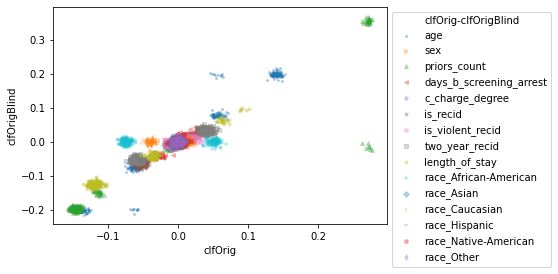

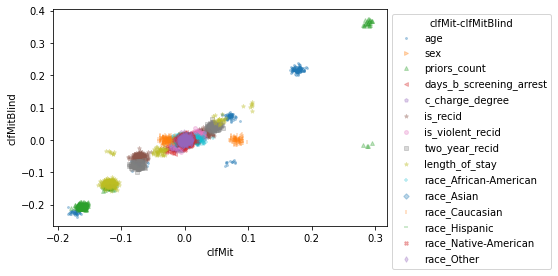

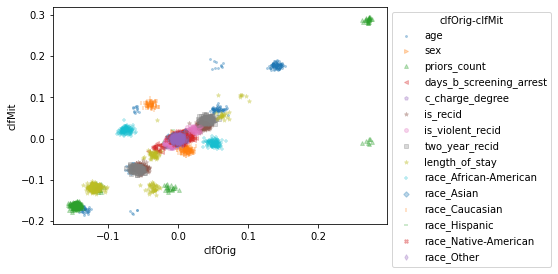

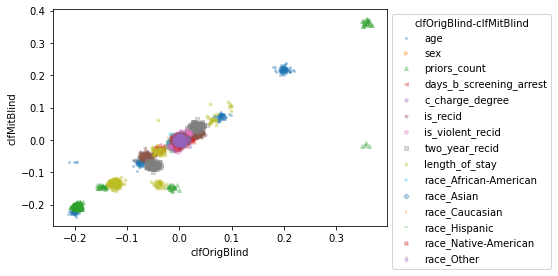

In [99]:
XAIPlots(lime_v,column_names,diffClfs=True)

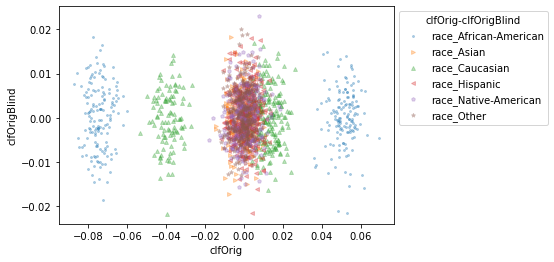

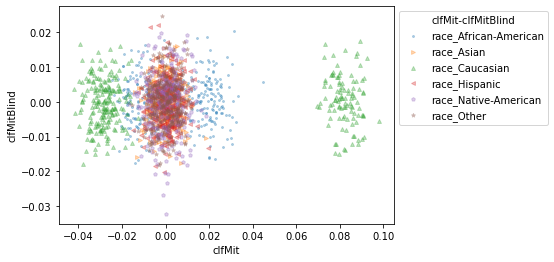

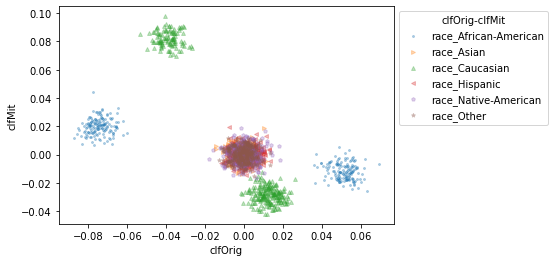

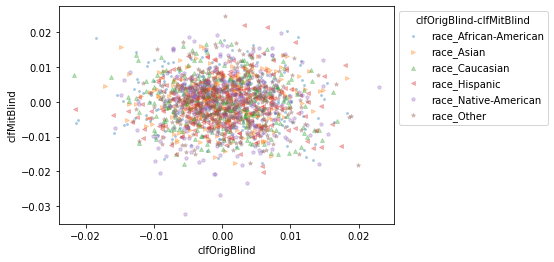

In [100]:
XAIPlots(lime_v,protected,diffClfs=True)

#### Comparison

##### SHAP Kernel Explainer

In [101]:
PIK = "PS_RF_SHAPV_Fix.dat"
with open(path_res+"/"+PIK, "rb") as f:
  shap_v_fix = pickle.load(f)

In [102]:
PIK = "PS_RF_SHAPV_Change.dat"
with open(path_res+"/"+PIK, "rb") as f:
  shap_v_change = pickle.load(f)

In [103]:
XAISum,XAIMean = deltas(shap_v_fix,column_names,False,shap_v_change)
XAISum

Empty DataFrame
Columns: []
Index: []

In [104]:
XAIMean

clfOrig-clfOrig  clfMit-clfMit  \
age                             0.003207       0.009289   
sex                             0.000183       0.000140   
priors_count                    0.001508       0.003725   
days_b_screening_arrest         0.000907       0.000705   
c_charge_degree                 0.000521       0.000463   
is_recid                        0.000728       0.001181   
is_violent_recid                0.000730       0.000997   
two_year_recid                  0.002169       0.002901   
length_of_stay                  0.003909       0.001881   
race_African-American           0.004191       0.000691   
race_Asian                      0.000004       0.000006   
race_Caucasian                  0.001236       0.002027   
race_Hispanic                   0.000080       0.000243   
race_Native-American            0.000012       0.000009   
race_Other                      0.000046       0.000039   

                         clfOrigBlind-clfOrigBlind  clfMitBlind-clfMitBlind  
age                                       0.002214                 0.005945  
sex                                       0.000135                 0.000594  
priors_count                              0.006027                 0.009226  
days_b_screening_arrest                   0.001537                 0.001564  
c_charge_degree                           0.000497                 0.000915  
is_recid                                  0.000647                 0.001654  
is_violent_recid                          0.000339                 0.000784  
two_year_recid                            0.001573                 0.001024  
length_of_stay                            0.001008                 0.008319  
race_African-American                     0.000000                 0.000000  
race_Asian                                0.000000                 0.000007  
race_Caucasian                            0.000000                 0.000004  
race_Hispanic                             0.000000                 0.000000  
race_Native-American                      0.000000                 0.000004  
race_Other                                0.000000                 0.000004

In [105]:
resSHAP = buildFinalResXAI(XAISum,XAIMean,protected,non_sensitive)
resSHAP = resSHAP.round(3)
resSHAP

clfOrig-clfOrig  clfMit-clfMit  clfOrigBlind-clfOrigBlind  \
SA-Mean             0.001          0.001                      0.000   
SA-Sd               0.002          0.001                      0.000   
NSA-Mean            0.002          0.002                      0.002   
NSA-Sd              0.001          0.003                      0.002   

          clfMitBlind-clfMitBlind  
SA-Mean                     0.000  
SA-Sd                       0.000  
NSA-Mean                    0.003  
NSA-Sd                      0.003

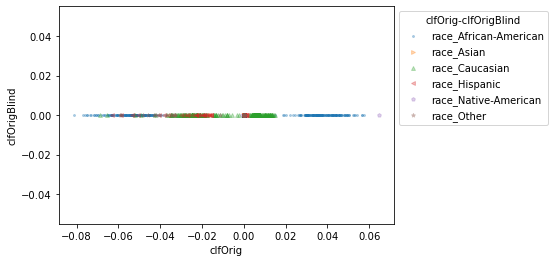

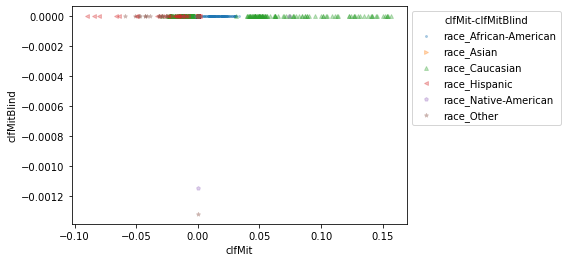

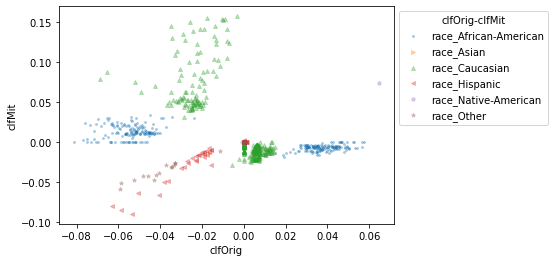

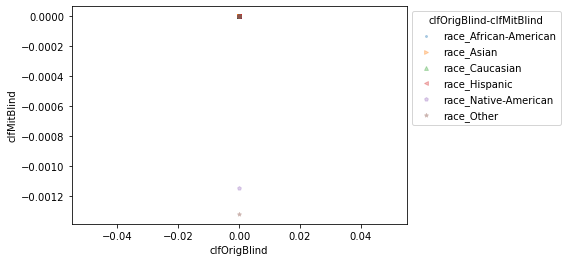

In [106]:
XAIPlots(shap_v_fix,protected,True,shap_v_change)

##### SHAP Explainer 4 Trees

In [ ]:
PIK = "PS_RF_SHAPV_Fix_Tree.dat"
with open(path_res+"/"+PIK, "rb") as f:
  shap_v_fix = pickle.load(f)

In [ ]:
PIK = "PS_RF_SHAPV_Change_Tree.dat"
with open(path_res+"/"+PIK, "rb") as f:
  shap_v_change = pickle.load(f)

In [ ]:
XAISum,XAIMean = deltas(shap_v_fix,column_names,False,shap_v_change)
XAISum

In [ ]:
XAIMean

In [ ]:
resSHAP = buildFinalResXAI(XAISum,XAIMean,protected,non_sensitive)
resSHAP = resSHAP.round(3)
resSHAP

In [ ]:
XAIPlots(shap_v_fix,protected,True,shap_v_change)

##### LIME

In [107]:
PIK = "PS_RF_LIMEV_Fix.dat"
with open(path_res+"/"+PIK, "rb") as f:
  lime_v_fix = pickle.load(f)

In [108]:
PIK = "PS_RF_LIMEV_Change.dat"
with open(path_res+"/"+PIK, "rb") as f:
  lime_v_change = pickle.load(f)

In [109]:
XAISum,XAIMean = deltas(lime_v_fix,column_names,False,lime_v_change)
XAISum

Empty DataFrame
Columns: []
Index: []

In [110]:
XAIMean

clfOrig-clfOrig  clfMit-clfMit  \
age                                  0.0       0.017233   
sex                                  0.0       0.001151   
priors_count                         0.0       0.022202   
days_b_screening_arrest              0.0       0.005017   
c_charge_degree                      0.0       0.006015   
is_recid                             0.0       0.003028   
is_violent_recid                     0.0       0.001407   
two_year_recid                       0.0       0.001307   
length_of_stay                       0.0       0.005950   
race_African-American                0.0       0.002098   
race_Asian                           0.0       0.002025   
race_Caucasian                       0.0       0.002638   
race_Hispanic                        0.0       0.002421   
race_Native-American                 0.0       0.001884   
race_Other                           0.0       0.002086   

                         clfOrigBlind-clfOrigBlind  clfMitBlind-clfMitBlind  
age                                       0.000078                 0.008885  
sex                                       0.000066                 0.002272  
priors_count                              0.000079                 0.035802  
days_b_screening_arrest                   0.000072                 0.007025  
c_charge_degree                           0.000079                 0.002099  
is_recid                                  0.000083                 0.003394  
is_violent_recid                          0.000079                 0.002709  
two_year_recid                            0.000084                 0.008138  
length_of_stay                            0.000084                 0.018745  
race_African-American                     0.000082                 0.002210  
race_Asian                                0.001533                 0.001863  
race_Caucasian                            0.000079                 0.002420  
race_Hispanic                             0.000979                 0.003296  
race_Native-American                      0.001854                 0.002813  
race_Other                                0.000079                 0.002174

In [111]:
resLIME = buildFinalResXAI(XAISum,XAIMean,protected,non_sensitive)
resLIME = resLIME.round(3)
resLIME

clfOrig-clfOrig  clfMit-clfMit  clfOrigBlind-clfOrigBlind  \
SA-Mean               0.0          0.002                      0.001   
SA-Sd                 0.0          0.000                      0.001   
NSA-Mean              0.0          0.007                      0.000   
NSA-Sd                0.0          0.007                      0.000   

          clfMitBlind-clfMitBlind  
SA-Mean                     0.002  
SA-Sd                       0.000  
NSA-Mean                    0.010  
NSA-Sd                      0.010

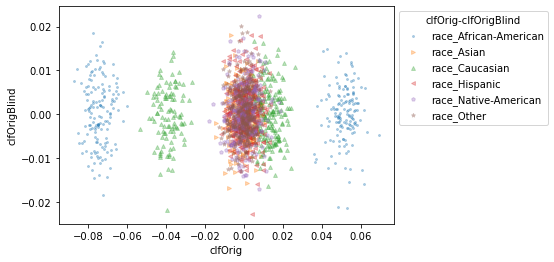

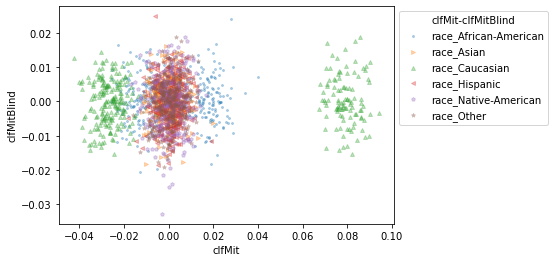

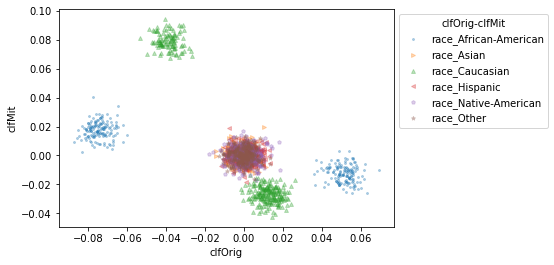

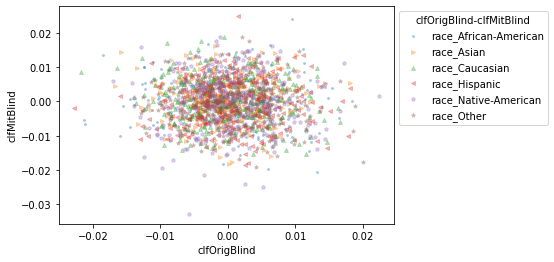

In [112]:
XAIPlots(lime_v_fix,protected,True,lime_v_change)